In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import regex as reg
%matplotlib inline

Loading the data about universities:

In [2]:
universities = pd.read_pickle('data/Universities.pkl')
universities.head()

file                               name        domain  \
0  import2018_371  University of Colorado at Boulder  colorado.edu   
1  import2018_371  University of Colorado at Boulder  colorado.edu   
2  import2018_371  University of Colorado at Boulder  colorado.edu   
3  import2018_417  Indiana University at Bloomington   indiana.edu   
4  import2018_417  Indiana University at Bloomington     gmail.com   

                             email  author_order        country        Lat  \
0     rebecca.swanson@colorado.edu             0  United States  40.006670   
1  leighanna.hinojosa@colorado.edu             1  United States  40.006670   
2       joseph.polman@colorado.edu             2  United States  40.006670   
3             huang220@indiana.edu             0  United States  39.167222   
4              agomoll90@gmail.com             1  United States  39.167222   

          Lon  
0 -105.267220  
1 -105.267220  
2 -105.267220  
3  -86.521389  
4  -86.521389

In [3]:
universities.rename(columns={'email': 'mail'}, inplace=True)

## Mapping the participants:

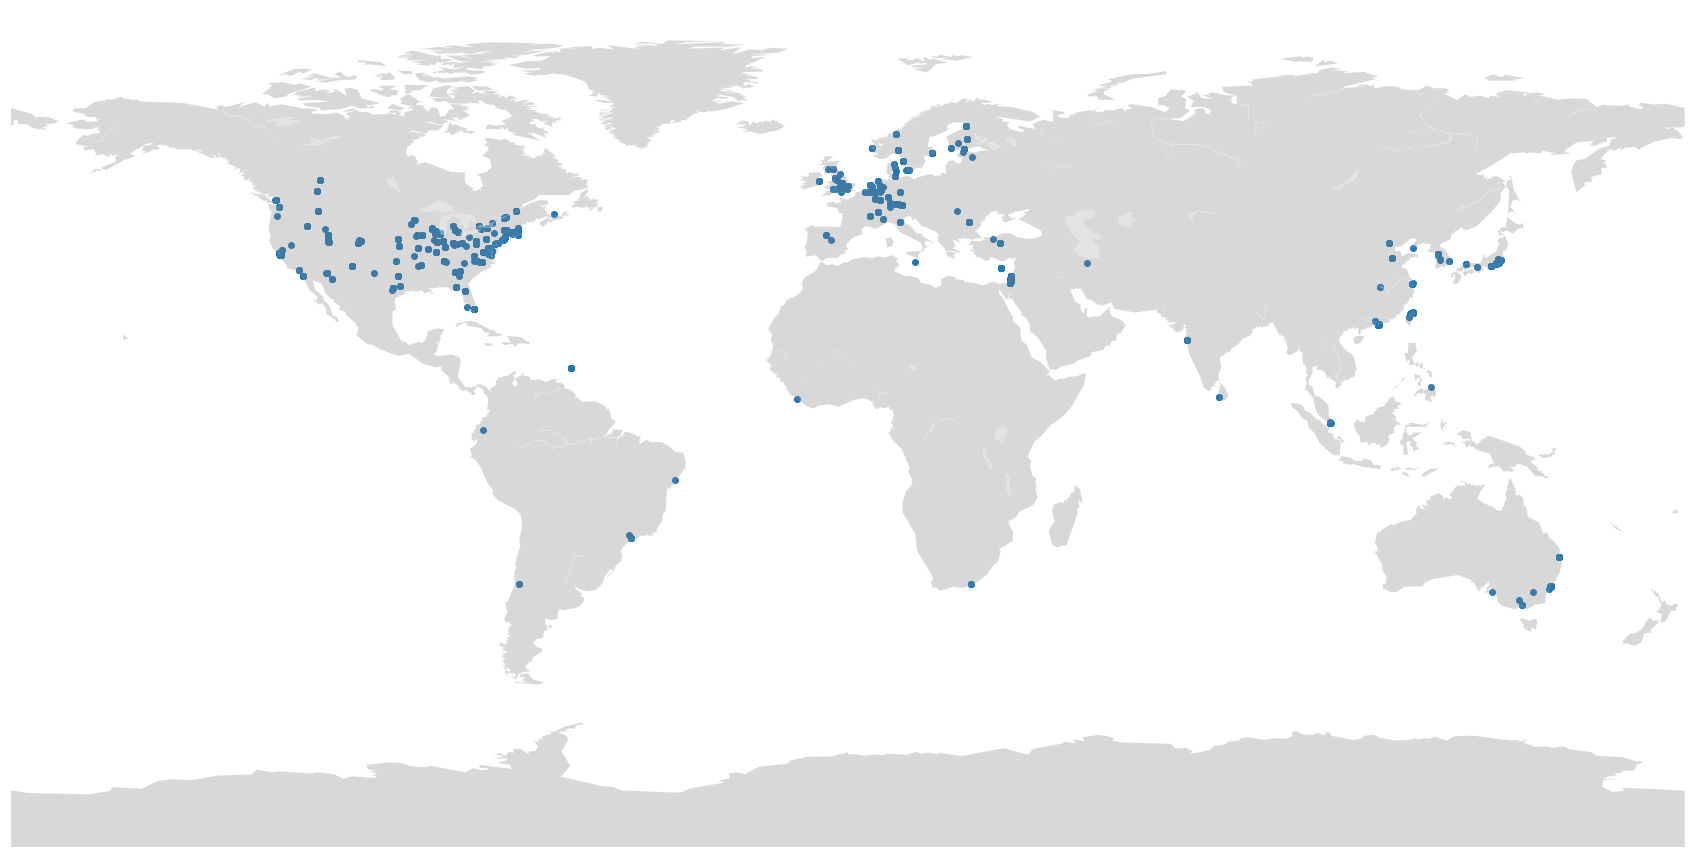

In [4]:
from mpl_toolkits.basemap import Basemap#run export PROJ_LIB=$CONDA_PREFIX/share/proj if this gives a key error

plt.figure(figsize=(30, 20))
m=Basemap()
m.drawmapboundary(linewidth=0)
m.fillcontinents(color='grey', alpha=0.3)
m.drawcoastlines(linewidth=0.1, color="white")
 
# prepare a color for each point depending on the continent.
data = universities.copy()
 
# Add a point per position
m.scatter(data['Lon'], data['Lat'])


## Base analysis of Universities present in dataset

#### What universities has the most contributors, and what percentage do they make up:

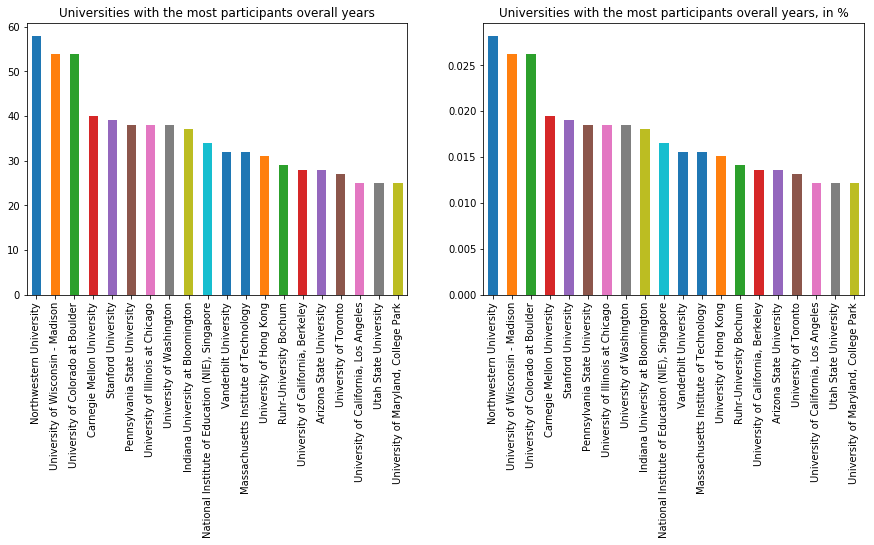

In [5]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.title('Universities with the most participants overall years')
universities[(~universities.mail.duplicated())].name.value_counts().head(20).plot(kind='bar')

plt.subplot(122)
plt.title('Universities with the most participants overall years, in %')
(universities[(~universities.mail.duplicated())].name.value_counts().head(20)/universities[(~universities.mail.duplicated())].shape[0]).plot(kind='bar')
plt.show()

#### What are the countries where the most contributors are?

As determined by university affiliation

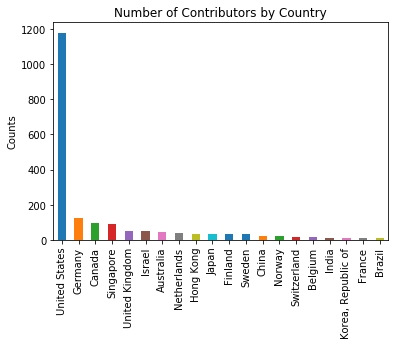

In [6]:
universities[(~universities.mail.duplicated())].country.value_counts().head(20).plot(kind = 'bar')
plt.title('Number of Contributors by Country') # as determinded by university affiliation
plt.ylabel('Counts')
plt.show()

## Considering ICLS and CSCL:

We look at which universities are present every year, only present during CSCL years and ICLS years:

In [7]:
metadata = pd.read_csv('data/Parsed_metadata.csv', index_col=0, parse_dates=['accessioned', 'available', 'issued'])
metadata.issued = metadata.issued.map(lambda x: x.year)

#dataframe with paper - author - author affiliations
grouping =  pd.merge(metadata, universities, on='file')
grouping = grouping[#only count a participant once (per year)
                    (~grouping[['issued', 'mail']].duplicated()) ]

#grouping =  pd.merge(metadata, universities, on='file')

In [8]:
#get universities by year
uni_year = grouping.groupby('issued').apply(lambda x: set(x['name']))

#get years in our dataset
years = uni_year.index.tolist()

#create a set of universities that have participated at some point
unis = uni_year.tolist()
all_ = set()
[all_.update(x) for x in unis]

#now use odd and even years to determine universities that participated every year in either ICLS or CSCL

all_years = unis[0]
ICLS = all_
CSCL = all_
for i, x in enumerate(unis):
    all_years = all_years.intersection(x)
    
    if years[i] % 2 == 0:
        ICLS = ICLS.intersection(x)
    else:
        CSCL = CSCL.intersection(x)

We now focus on universities that participated uniquely on one or the other conference:

In [9]:
ICLS, CSCL = ICLS.difference(CSCL), CSCL.difference(ICLS)

In [10]:
print('Number of universities represeted every year: ', len(all_years))
print('Number of universities represeted at every ICLS but not CSCL: ', len(ICLS))
print('Number of universities represeted at every CSCL but not ICLS: ', len(CSCL))

Number of universities represeted every year:  37
Number of universities represeted at every ICLS but not CSCL:  55
Number of universities represeted at every CSCL but not ICLS:  9


We now look into publication counts per university over the years:

In [11]:
grouping =  pd.merge(metadata, universities, on='file')
grouping = grouping[ #only count a participant once (per year)
                    (~grouping[['issued', 'mail']].duplicated()) & 
                    #only consider universities that participated every year
                    (grouping.name.isin(all_years))]

ranks = pd.DataFrame(grouping.groupby('issued').name.value_counts())
ranks.columns = ['count']
ranks.reset_index(inplace=True)
ranks.head()

issued                               name  count
0    2015              University of Toronto     12
1    2015                Göteborg University      9
2    2015         Universität Duisburg-Essen      9
3    2015                EPFL - EPF Lausanne      8
4    2015  Indiana University at Bloomington      8

There seems to be some patter indicating that even amongst universities that participate every year, there is a fluctiation of numbr of papers between ICLS and CSCL

In [12]:
#we only look at universities that have at least two submissions  each year
all_ = set()
ranks[ranks['count'] > 2].groupby('issued').apply(lambda x: all_.update(set(x['name'])))

for s in ranks[ranks['count'] > 2].groupby('issued').apply(lambda x: set(x['name'])).tolist():
    all_ = all_.intersection(s)

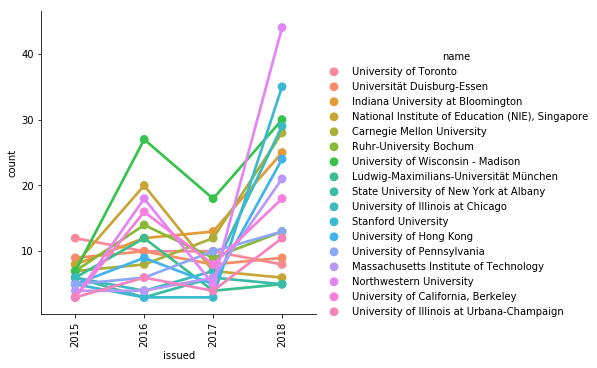

In [13]:
sns.catplot(data=ranks[ranks['name'].isin(all_) ], x='issued', y='count',kind='point', hue='name')
plt.xticks(rotation=90)
plt.show()

### Plotting the difference on a map:

In [14]:
ranks = pd.merge(ranks, universities, on='name', 
                  how='left')[['issued', 'name', 'count', 'Lon', 'Lat']].drop_duplicates().reset_index(drop=True)

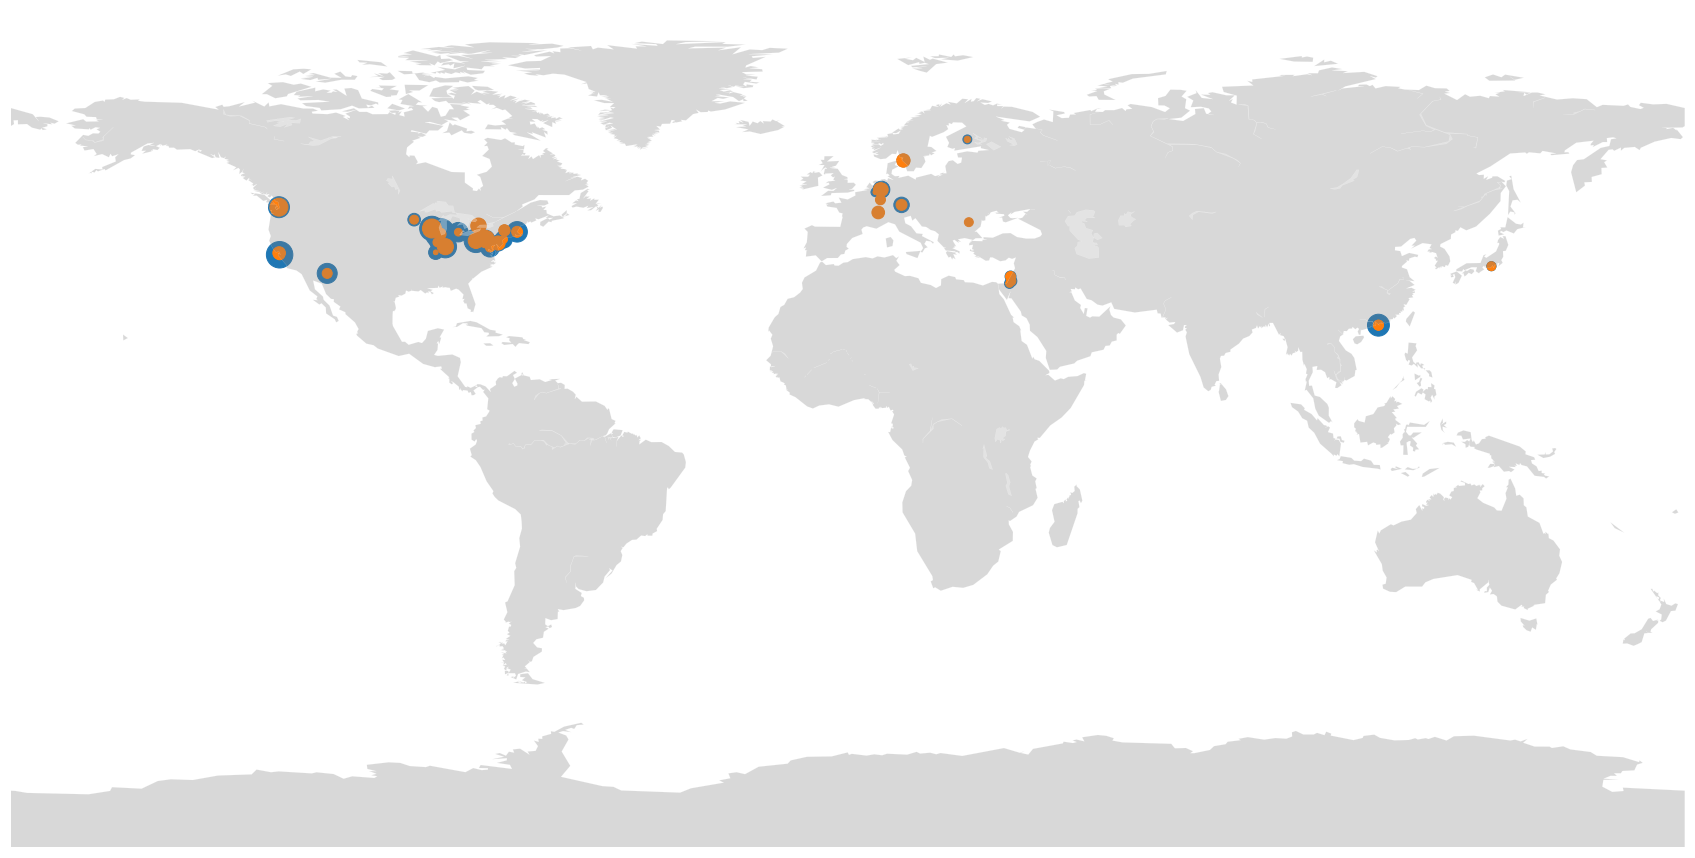

In [15]:
plt.figure(figsize=(30, 20))
m=Basemap()
m.drawmapboundary(linewidth=0)
m.fillcontinents(color='grey', alpha=0.3)
m.drawcoastlines(linewidth=0.1, color="white")
 
# prepare a color for each point depending on the continent.
data = ranks[ranks.issued%2 == 0].copy()
 
# Add a point per position
m.scatter(data['Lon'], data['Lat'], s=data['count']*20, cmap=plt.cm.Set2)

data = ranks[ranks.issued%2 == 1].copy()
 
# Add a point per position
m.scatter(data['Lon'], data['Lat'], s=data['count']*20, cmap=plt.cm.Set1)


### Do the same thing with countries

We have an interessting result:

Increase in number of participants is mostly due to new participants from the us.

In [16]:
uni_year = grouping.groupby('issued').apply(lambda x: set(x['country']))
years = uni_year.index.tolist()
unis = uni_year.tolist()
all_ = set()
[all_.update(x) for x in unis]

all_years = unis[0]
ICLS = all_
CSCL = all_


for i, x in enumerate(unis):
    all_years = all_years.intersection(x)

In [17]:
grouping =  pd.merge(metadata, universities, on='file')
grouping = grouping[(grouping.name != 'gmail') & 
                    #only count a participant once (per year)
                    (~grouping[['issued', 'mail']].duplicated()) & 
                    #only consider universities that participated every year
                    (grouping.country.isin(all_years))]


ranks = pd.DataFrame(grouping.groupby('issued').country.value_counts())
ranks.columns = ['count']
ranks.reset_index(inplace=True)

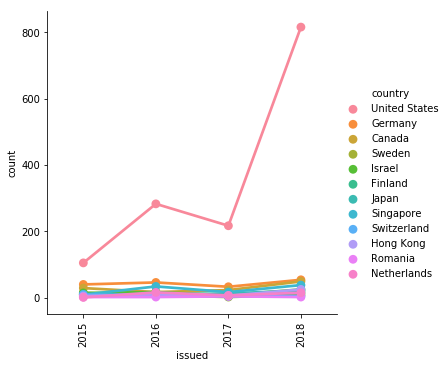

In [18]:
sns.catplot(data=ranks, x='issued', y='count',kind='point', hue='country')
plt.xticks(rotation=90)
plt.show()

Looking at it without america:

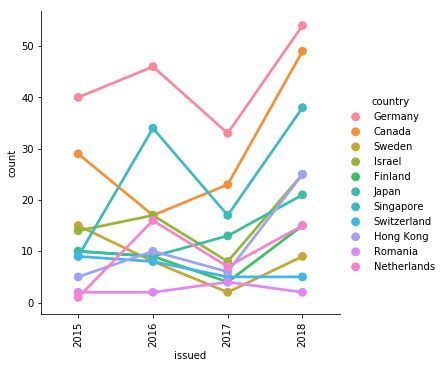

In [19]:
sns.catplot(data=ranks[(ranks.country != 'United States')], x='issued', y='count',kind='point', hue='country')
plt.xticks(rotation=90)
plt.show()

We now take an alternative view at countries, to see evolution in percentage:

In [20]:
grouping =  pd.merge(metadata, universities, on='file')
grouping = grouping[(grouping.name != 'gmail') & 
                    #only count a participant once (per year)
                    (~grouping[['issued', 'mail']].duplicated())]

In [21]:
viz = pd.DataFrame(grouping[['country', 'name', 'file', 'issued']].groupby(['issued', 'country']).name.value_counts())
viz.columns = ['counts']
viz.reset_index(inplace=True)

Set a colorbar to get more readable plot:

In [22]:
country_bar = pd.DataFrame(viz.groupby(['country', 'issued']).counts.sum()/viz.groupby(['issued']).counts.sum()*100).copy()
country_bar.columns = ['counts']
country_bar.reset_index(inplace=True)
to_ignore = country_bar.loc[country_bar.counts < 1].country.unique()
country_bar.loc[country_bar.country.isin(to_ignore), 'country'] = 'Other'
country_bar = country_bar.groupby(['country', 'issued']).sum()
country_bar.columns = ['counts']
country_bar.reset_index(inplace=True)

country_bar.head()

country  issued     counts
0  Australia    2015   3.819444
1  Australia    2016   2.761341
2  Australia    2017   1.630435
3  Australia    2018   1.778154
4     Canada    2015  10.069444

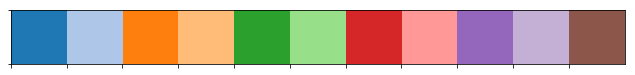

In [23]:
categories = country_bar.country.unique()
palette = sns.color_palette(palette='tab20', n_colors=len(categories)+1)

sns.palplot(palette)

We see that america makes up a bigger and bigger percentage

Text(0.5, 1.0, 'Participants by country (%)')

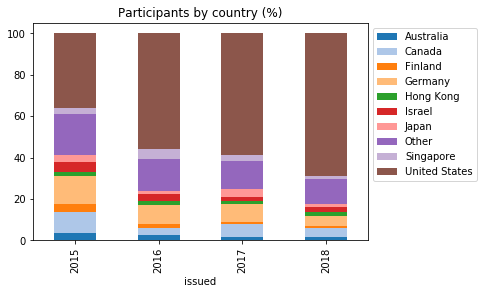

In [24]:
from matplotlib.colors import ListedColormap

country_bar = country_bar.pivot(index='issued', columns='country')
country_bar.columns = country_bar.columns.droplevel()

country_bar.plot(kind='bar', stacked=True, colormap=ListedColormap(palette))
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Participants by country (%)')

In terms of absolute attendance, countries with less than 4 participants in any year are grouped into other to improve visibility:

Text(0.5, 1.0, 'Participants by country by conference')

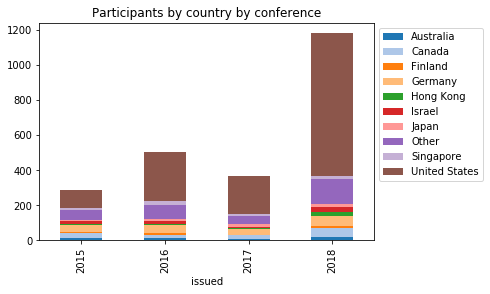

In [25]:
country_bar = pd.DataFrame(viz.groupby(['country', 'issued']).counts.sum()).copy()
country_bar.columns = ['counts']
country_bar.reset_index(inplace=True)
country_bar.loc[country_bar.country.isin(to_ignore), 'country'] = 'Other'
country_bar = country_bar.groupby(['country', 'issued']).sum()
country_bar.columns = ['counts']
country_bar.reset_index(inplace=True)

categories = country_bar.country.unique()
palette = sns.color_palette(palette='tab20', n_colors=len(categories)+1)

country_bar = country_bar.pivot(index='issued', columns='country')
country_bar.columns = country_bar.columns.droplevel()
country_bar.plot(kind='bar', stacked=True, colormap=ListedColormap(palette))
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Participants by country by conference')

From before we know that some universities have very large increase, therefore we look at the increase in america more closely. We see that there are a lot more of authors from various universities contributing, which weren't contributing before.

Text(0.5, 1.0, 'Participants by US-university by conference')

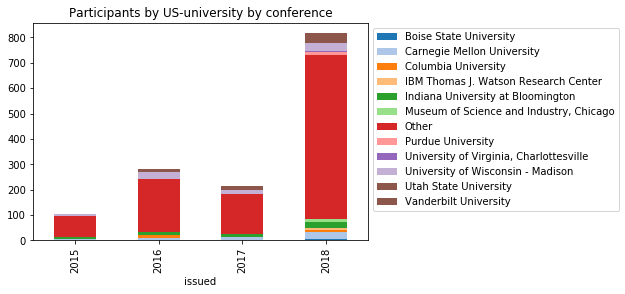

In [26]:
uni_bar = viz[viz.country == 'United States']
uni_bar = pd.DataFrame(uni_bar.groupby(['name', 'issued']).counts.sum()).copy()
uni_bar.columns = ['counts']
uni_bar.reset_index(inplace=True)

to_ignore = uni_bar.loc[uni_bar.counts < 6].name.unique()

uni_bar.loc[uni_bar.name.isin(to_ignore), 'name'] = 'Other'
uni_bar = uni_bar.groupby(['name', 'issued']).sum()
uni_bar.columns = ['counts']
uni_bar.reset_index(inplace=True)

uni_bar = uni_bar.pivot(index='issued', columns='name')
uni_bar.columns = uni_bar.columns.droplevel()
uni_bar.plot(kind='bar', stacked=True, colormap=ListedColormap(palette))

plt.legend(bbox_to_anchor=(1, 1))
plt.title('Participants by US-university by conference')

Text(0.5, 1.0, 'Participants by country by conference')

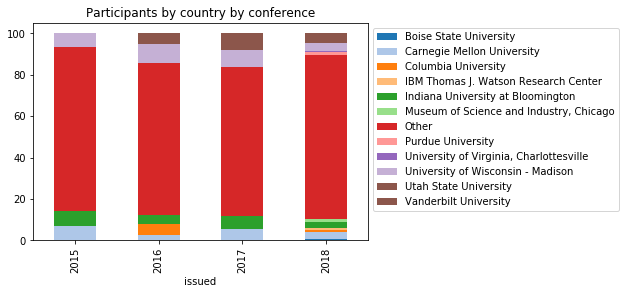

In [27]:
uni_bar = viz[viz.country == 'United States']
uni_bar = pd.DataFrame(uni_bar.groupby(['name', 'issued']).counts.sum()/uni_bar.groupby(['issued']).counts.sum()*100).copy()
uni_bar.columns = ['counts']
uni_bar.reset_index(inplace=True)
uni_bar.loc[uni_bar.name.isin(to_ignore), 'name'] = 'Other'
uni_bar = uni_bar.groupby(['name', 'issued']).sum()
uni_bar.columns = ['counts']
uni_bar.reset_index(inplace=True)

uni_bar = uni_bar.pivot(index='issued', columns='name')
uni_bar.columns = uni_bar.columns.droplevel()
uni_bar.plot(kind='bar', stacked=True, colormap=ListedColormap(palette))

plt.legend(bbox_to_anchor=(1, 1))
plt.title('Participants by country by conference')

In [28]:
uni_bar

name    Boise State University  Carnegie Mellon University  \
issued                                                       
2015                       NaN                    6.730769   
2016                       NaN                    2.826855   
2017                       NaN                    5.555556   
2018                  0.735294                    3.431373   

name    Columbia University  IBM Thomas J. Watson Research Center  \
issued                                                              
2015                    NaN                                   NaN   
2016               5.300353                                   NaN   
2017                    NaN                                   NaN   
2018               0.980392                              0.857843   

name    Indiana University at Bloomington  \
issued                                      
2015                             7.692308   
2016                             4.240283   
2017                             6.018519   
2018                             3.063725   

name    Museum of Science and Industry, Chicago      Other  Purdue University  \
issued                                                                          
2015                                        NaN  78.846154                NaN   
2016                                        NaN  73.144876                NaN   
2017                                        NaN  72.222222                NaN   
2018                                   1.102941  79.411765            1.22549   

name    University of Virginia, Charlottesville  \
issued                                            
2015                                        NaN   
2016                                        NaN   
2017                                        NaN   
2018                                   0.735294   

name    University of Wisconsin - Madison  Utah State University  \
issued                                                             
2015                             6.730769                    NaN   
2016                             9.540636               2.826855   
2017                             8.333333               4.629630   
2018                             3.676471               1.960784   

name    Vanderbilt University  
issued                         
2015                      NaN  
2016                 2.120141  
2017                 3.240741  
2018                 2.818627

# Looking at where people collaborate:

## Building a collaboration graph, only taking into consideration countries:

We use the author index to match up author names with indices:

In [29]:
universities['merge_index'] = universities.apply(lambda x: x['file']+str(x['author_order']), axis=1)
metadata['merge_index'] = metadata.apply(lambda x: x['file']+str(x['author_order']), axis=1)
associations = pd.merge(universities, metadata, on='merge_index')

In [30]:
pub_collab = associations[['file_x','country', 'name']].drop_duplicates()
collabs = pd.merge(pub_collab, pub_collab, on='file_x').drop_duplicates()
collabs.dropna(inplace=True)
#collabs = collabs[collabs.country_x != collabs.country_y]
collabs.head()

file_x      country_x                             name_x  \
0  import2018_371  United States  University of Colorado at Boulder   
1  import2018_417  United States  Indiana University at Bloomington   
2  import2018_417  United States  Indiana University at Bloomington   
3  import2018_417  United States                 Indiana University   
4  import2018_417  United States                 Indiana University   

       country_y                             name_y  
0  United States  University of Colorado at Boulder  
1  United States  Indiana University at Bloomington  
2  United States                 Indiana University  
3  United States  Indiana University at Bloomington  
4  United States                 Indiana University

Building collaboration graph:

In [31]:
nodes = pd.DataFrame(collabs.country_x.dropna().unique())
nodes.columns = ['country']
nodes.reset_index(inplace=True)
nodes.head()

index         country
0      0   United States
1      1         Germany
2      2  United Kingdom
3      3       Singapore
4      4          Canada

In [32]:
country_index = nodes.country.to_dict()
country_index = {v: k for k, v in country_index.items()}

collabs['index_x'] = collabs.country_x.map(country_index)
collabs['index_y'] = collabs.country_y.map(country_index)

edges = collabs[['index_x', 'index_y']].copy()

In [33]:
def get_adjacency(nodes, edges):
    n_nodes = len(nodes)
    adjacency = np.zeros((n_nodes, n_nodes), dtype=int)

    for idx, row in edges.iterrows():
        i, j = int(row.index_x), int(row.index_y)
        adjacency[i, j] += 1
        adjacency[j, i] = adjacency[i, j]


    return adjacency

In [34]:
adjacency = get_adjacency(nodes, edges)

In [35]:
n_nodes = len(nodes)
graph = nx.from_numpy_array(adjacency - np.identity(n_nodes)*adjacency)
mapping = nodes.country.to_dict()

Visualizing the adjacency matrix:

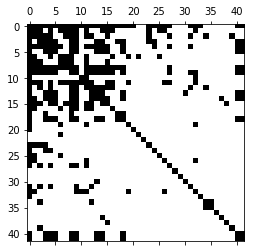

In [36]:
plt.spy(adjacency)

## Most collaborative countries

The number represented is: number of different papers written in collaboration with an other country.
Clearly, as the owerall number of papers for the us is extremly hight, the US will dominate this graph:

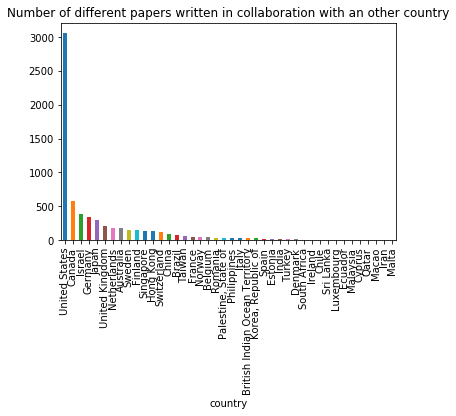

In [37]:
nodes['degrees'] = pd.Series(adjacency.sum(axis=1))
plt.title('Number of different papers written in collaboration with an other country')
nodes.set_index('country').degrees.sort_values(ascending=False).plot(kind='bar')

What country has most collaborations with different countries?
That the number on the y axis is the number of countries the country on the x axis collaborates with: 

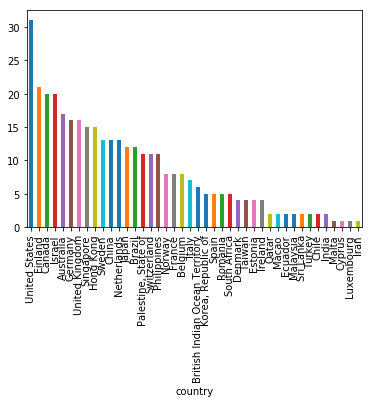

In [38]:
nodes['degrees'] = pd.Series(np.where(adjacency > 0, 1, 0).sum(axis=1))
nodes.set_index('country').degrees.sort_values(ascending=False).plot(kind='bar')

## Isolated Countries

In [39]:
zero_collabs = np.where((adjacency - adjacency*np.identity(n_nodes)).sum(axis=1) == 0)
nodes.iloc[zero_collabs]

index     country  degrees
22     22        Iran        1
28     28  Luxembourg        1
29     29       Malta        1
36     36      Cyprus        1

## Looking at the countries that do collaborate:

The total number of connected components (including isolated nodes) is:

In [40]:
nx.number_connected_components(graph)

5

Hence all other countries are part of the main component.

To more easely visualize the graph we extract the largest component and try to partition/cluster the graph in some way. Here we use the kernighan lin bisection algorithm to find a bisection. The bisection groupy the countries into countries with a lot of collaboration and little collaboration.

In [41]:
components = nx.connected_components(graph)
largest_cc = max(nx.connected_components(graph), key=len)
graph = graph.subgraph(largest_cc)

In [42]:
#remove countries not in largest component
mapping = {k:mapping[k] for k in largest_cc if k in mapping}

In [43]:
from networkx.algorithms.community import kernighan_lin_bisection
c = list(kernighan_lin_bisection(graph))

In [44]:
def matching_by_criteria(c):
    member_label = {}
    for index, community in enumerate(c):
        members = list(community)
        for m in members:
            member_label[m] = index
    return member_label

country_partition = matching_by_criteria(c)

Change size of nodes based on with how many other countries a country interacts:

We use degree centrality, which will be large for countries with a lot of collaboration and small for countries with little collaboration.

In [45]:
node_size = (np.array(list(nx.degree_centrality(graph).values())))*1000

/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


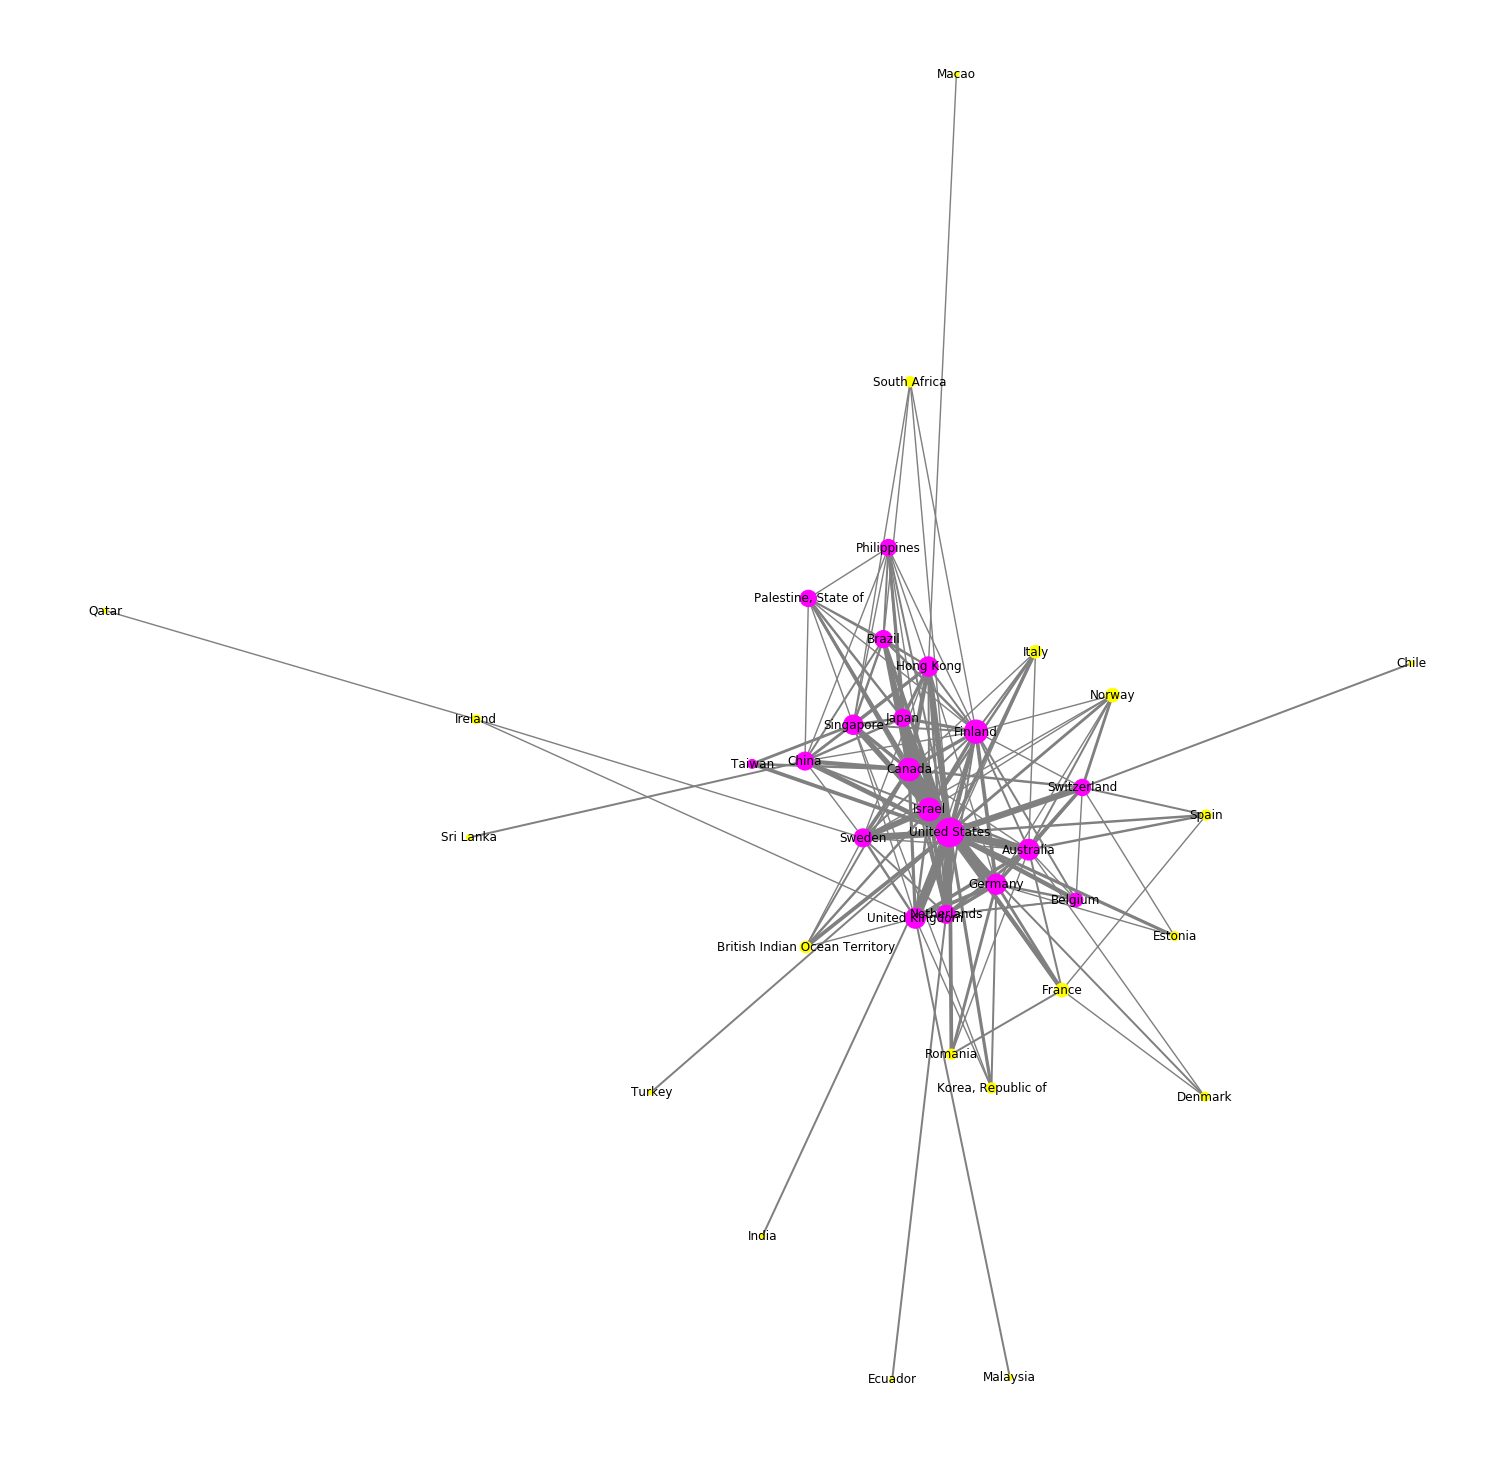

In [46]:
plt.figure(figsize=(20, 20))
nx.draw_spring(graph,  edge_color='grey', 
               node_color=pd.Series(country_partition).sort_index().tolist(), 
               width = np.sqrt(np.array(list(nx.get_edge_attributes(graph, 'weight').values()))),
               #edge_color = list(nx.get_edge_attributes(graph, 'weight').values()),
               #edge_cmap = plt.cm.gray_r,
               cmap='spring', 
               node_size=node_size, 
               labels=mapping)

In [47]:
edges_drawing = np.array(list(nx.get_edge_attributes(graph, 'weight').values()))

/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


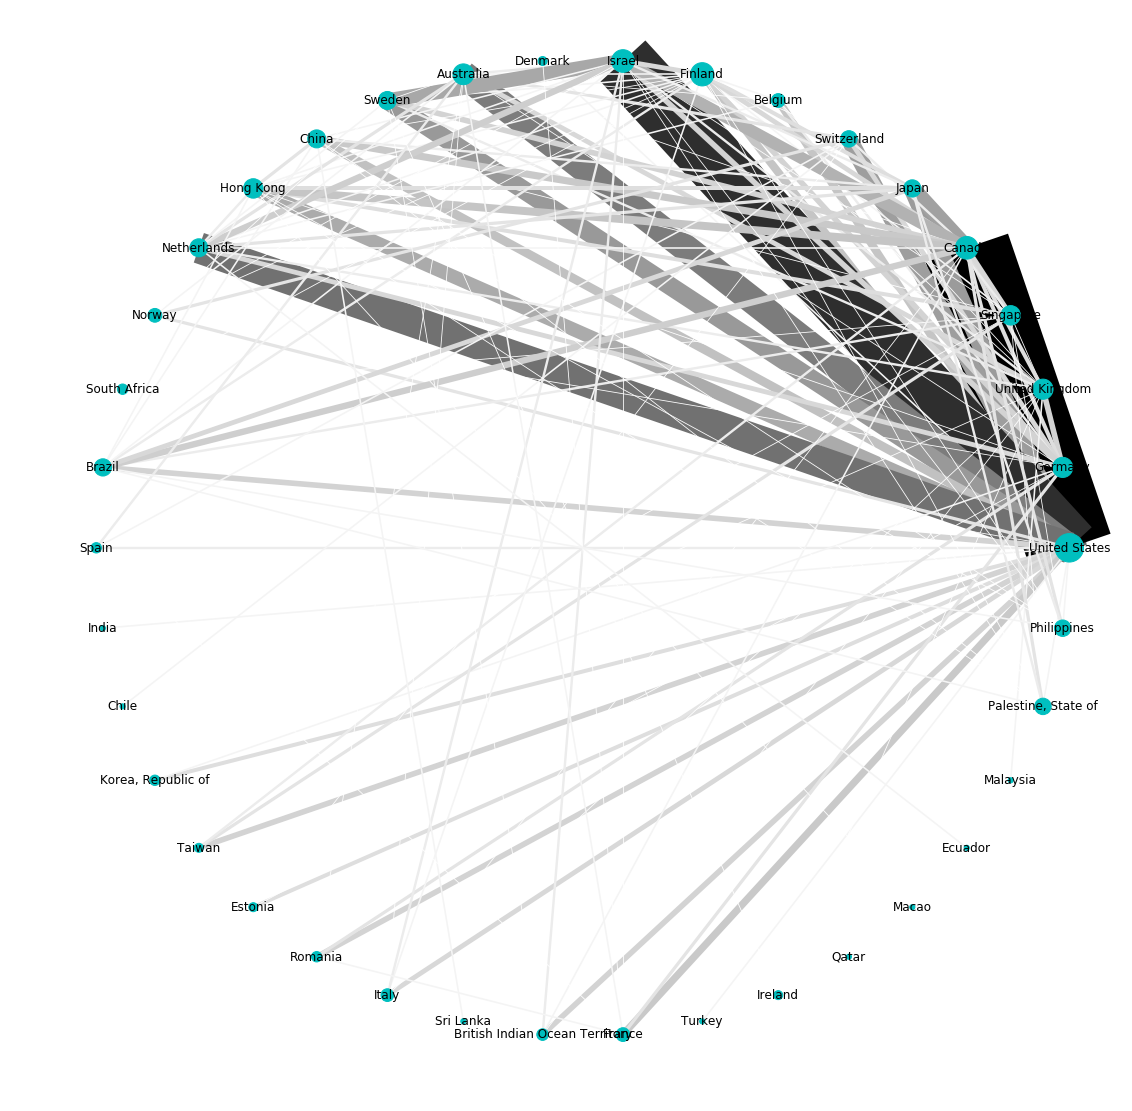

In [48]:
plt.figure(figsize=(15, 15))
nx.draw_circular(graph, 
               node_color='c', 
               width = edges_drawing/2.5,
               edge_color = np.sqrt(edges_drawing)/2,
               edge_cmap = plt.cm.gray_r,
               node_size=node_size, 
               labels=mapping)

# Do the same for university as we did for country:

Find who collaborated with whom on a paper and turn the resulting edge list into a graph:

In [49]:
pub_collab = associations[['file_x','name', 'country']].drop_duplicates()
pub_collab = pub_collab[pub_collab.name != 'gmail']
collabs = pd.merge(pub_collab, pub_collab, on='file_x').drop_duplicates()

#collabs = collabs[collabs.name_x != collabs.name_y]

nodes = pd.DataFrame(collabs.name_x.dropna().unique())
nodes.columns = ['name']
nodes.reset_index(inplace=True)

In [50]:
uni_index = nodes.name.to_dict()
uni_index = {v: k for k, v in uni_index.items()}

collabs['index_x'] = collabs.name_x.map(uni_index)
collabs['index_y'] = collabs.name_y.map(uni_index)

edges = collabs[['index_x', 'index_y']].dropna()

In [51]:
adjacency = get_adjacency(nodes, edges)
n_nodes = len(nodes)
graph = nx.from_numpy_array(adjacency - np.identity(n_nodes)*adjacency)
mapping = nodes.name.to_dict()

H=nx.relabel_nodes(graph,mapping)

### Most collaborative universities:

number of different papers written in collaboration with an other university.

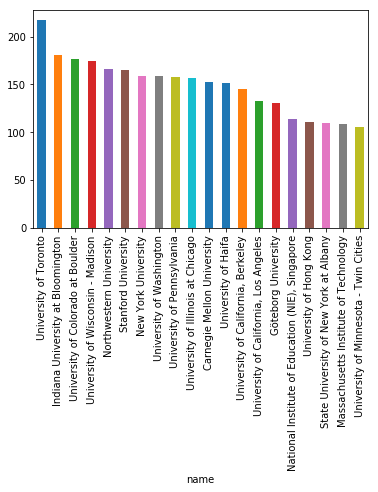

In [52]:
nodes['degrees'] = pd.Series(adjacency.sum(axis=1))
nodes.set_index('name').degrees.sort_values(ascending=False).head(20).plot(kind='bar')

Number of distinct different institution collbaorations:
The number on the y axis is the number of different institutions a university collaborated with (without counting how often the did this.)

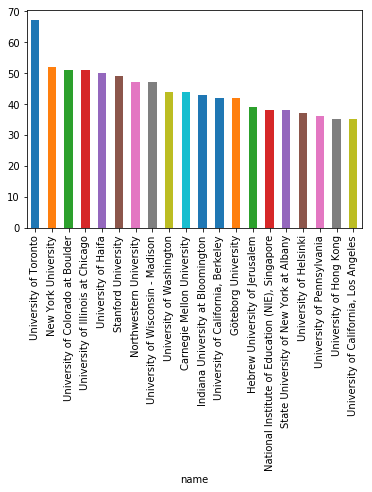

In [53]:
nodes['degrees'] = pd.Series(np.where(adjacency > 0, 1, 0).sum(axis=1))
nodes.set_index('name').degrees.sort_values(ascending=False).head(20).plot(kind='bar')

## Isolated universities:

Analyzing Universities that have not collaborated with other universities:

In [54]:
zero_collabs = np.where((adjacency - adjacency*np.identity(n_nodes)).sum(axis=1) == 0)
zero_collabs[0].shape

(42,)

In [55]:
nodes.iloc[zero_collabs][nodes.name.map(lambda x: True  if reg.search('\p{Lu}', x) else False)]

/anaconda3/envs/Biblio/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


index                                               name  degrees
40      40                                  Aarhus University        1
69      69                                Brandeis University        1
77      77             University of Massachusetts at Amherst        1
101    101                        Aalborg University, Denmark        1
110    110                  University of Missouri - Columbia        1
111    111                          Oklahoma State University        1
116    116                                 Harding University        1
124    124                         Tarbiat Modares University        1
125    125                               Stockholm University        1
135    135                                 Hanyang University        1
153    153                    Georgia Institute of Technology        1
166    166                               University of Geneva        1
172    172                                             WestEd        1
173    173                        College of William and Mary        1
185    185                                University of Malta        1
187    187                                               ITEC        1
215    215                                      Smith College        1
219    219                            University of Groningen        1
220    220             Texas A&M University - College Station        1
247    247                                Boğaziçi University        1
261    261                          University of Connecticut        1
262    262                       Saint John's University (NY)        1
266    266             Korea National University of Education        1
268    268  SRI International, Center for Technology and L...        1
272    272                            University of Cambridge        1
276    276                            Ewha Women's University        1
284    284            State University of New York at Buffalo        1
295    295                              Kent State University        1
296    296               IBM Thomas J. Watson Research Center        1
299    299                              University of Florida        1
300    300                        Central Michigan University        1
301    301                                   Grinnell College        1
302    302                    Cyprus University of Technology        1
317    317                                 Cardiff University        1
318    318                                    Lund University        1
319    319                University of New Hampshire, Durham        1
320    320                                              CEFET        1
321    321                    University of Northern Colorado        1
330    330                         Montclair State University        1
344    344                        City University of New York        1
353    353                                          KU Leuven        1
371    371   Homi Bhabha Centre for Science Education, Mumbai        1

## Analyzing main group of universities interacting:

We only look at largest component and ignore universities that don't belong to the main cluster

In [56]:
components = nx.connected_components(graph)
largest_cc = max(components, key=len)

main_universities = graph.subgraph(largest_cc)

Number of components of universities that collaborate outside of main cluster:

In [57]:
nx.number_connected_components(graph) - zero_collabs[0].shape[0]-1

10

We look at the smaller connected components with at least 3 nodes:

/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


188            Shandong University
189     Liaoning Normal University
190    National Science Foundation
Name: name, dtype: object


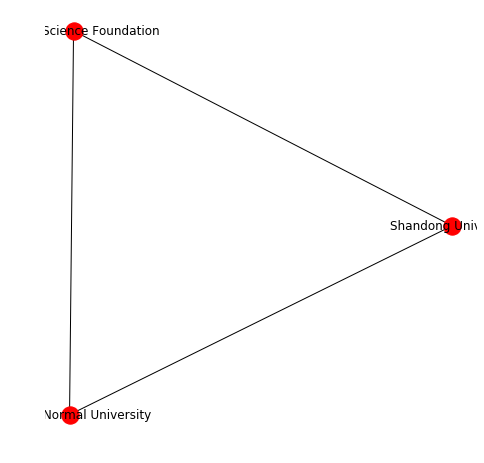

/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


258    Illinois State University
259       Wake Forest University
260    Missouri State University
Name: name, dtype: object


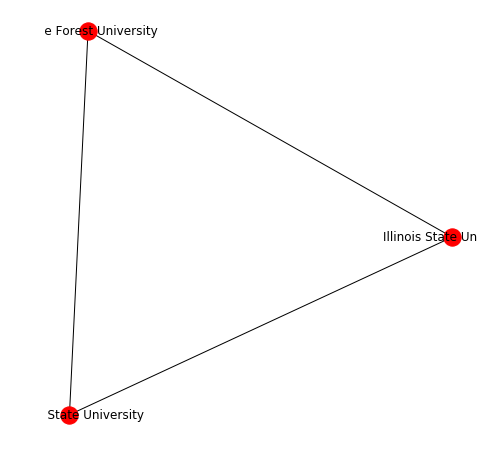

In [58]:
for g in list(nx.connected_component_subgraphs(graph)):
   
    if len(g.nodes) > 2 and len(g.nodes) < len(largest_cc):
        plt.figure(figsize=(6, 6))
        nx.draw_spring(g, labels=nodes.iloc[list(g.nodes)].name.to_dict())
        print(nodes.iloc[list(g.nodes)].name)
        plt.show()

### Main component

We partition the nodes to find "communities" of universities. They are the colored with the same color

In [59]:
from networkx.algorithms.community import greedy_modularity_communities
partition = list(greedy_modularity_communities(main_universities))
uni_partition = matching_by_criteria(partition)

Our partitioning algorthims finds 14 communities:

In [60]:
len(partition)

15

Change size of nodes based on with how many other countries a country interacts: the more connections the other nodes it has the larger the node will be.


For readability only nodes with some of the largest values –universities who are at the center of collaboration– are labeled. 

In [61]:
node_size = np.array(list(nx.degree_centrality(main_universities).values()))
edge_width = np.array(list(nx.get_edge_attributes(main_universities, 'weight').values()))

In [62]:
np.sqrt(edge_width).max()

4.69041575982343

In [63]:
nodes.loc[list(largest_cc),'node_size'] = node_size

In [64]:
labels = nodes.iloc[list(largest_cc)][nodes.node_size > np.percentile(node_size, 97.5)].name

/anaconda3/envs/Biblio/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


The color pallete for each cluster corresponds to the following cluster number:

   1  ||  2  ||  3  ||  4  ||  5  ||  6  ||  7  ||  8  ||  9  ||  10  ||  11  ||  12  ||  13  ||  14  ||  15


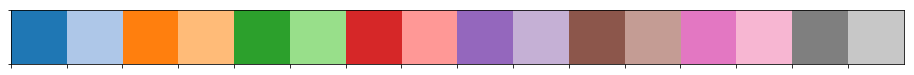

In [65]:
palette = sns.color_palette(palette='tab20', n_colors=len(partition)+1)

sns.palplot(palette)
print('  ', '  ||  '.join([str(i) for i in list(range(1,len(partition)+1))]))

/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


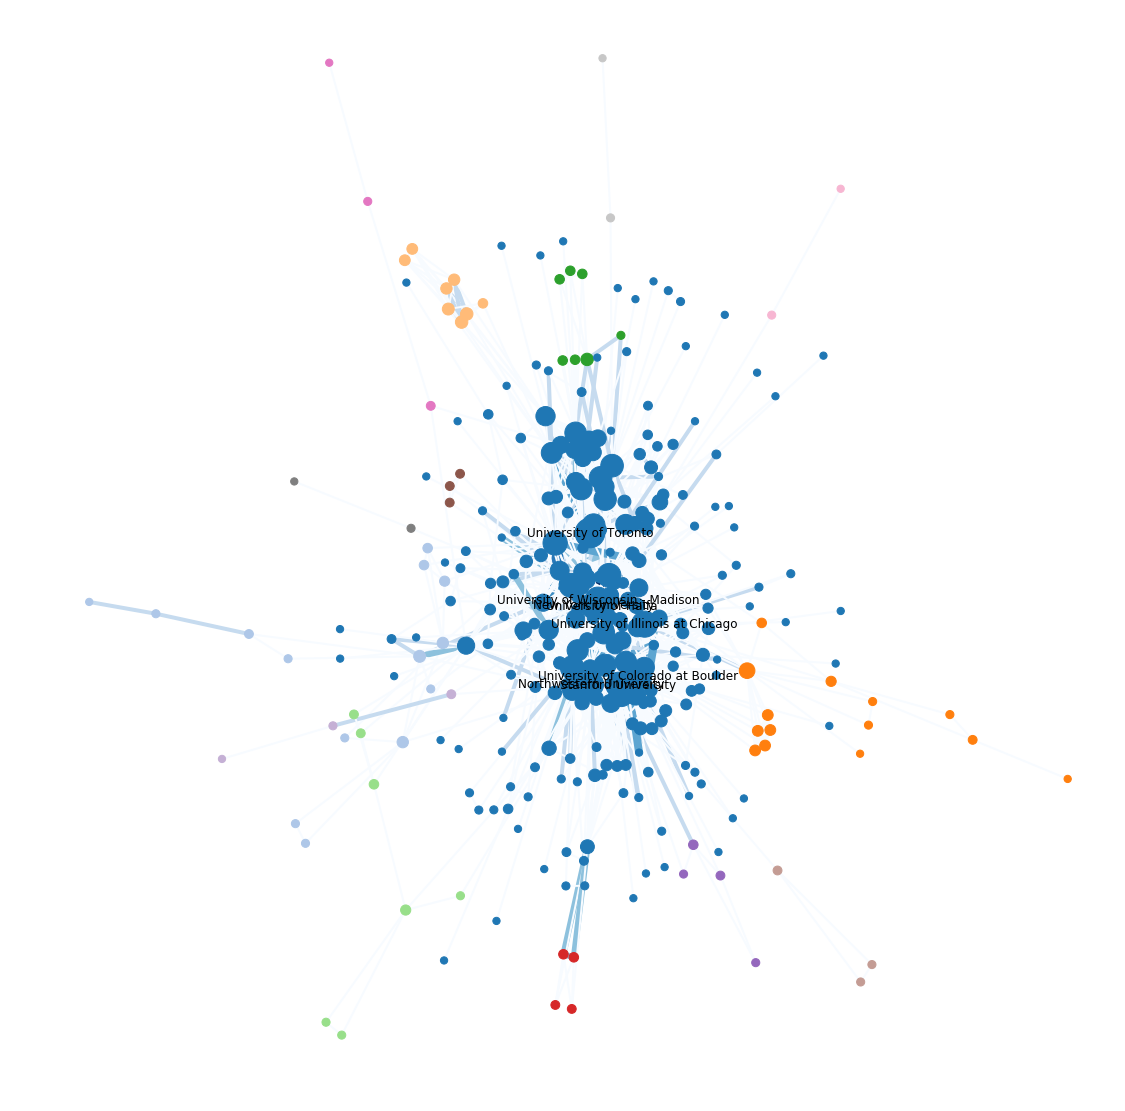

In [66]:
plt.figure(figsize=(15, 15))
nx.draw_spring(main_universities,  #edge_color='grey', 
               node_color=pd.Series(uni_partition).sort_index().tolist(),
               width = edge_width,
               edge_color = np.log(edge_width+1),
               edge_cmap = plt.cm.Blues,
               cmap=ListedColormap(palette.as_hex()), 
               node_size=(node_size+0.01)*4000, 
               labels=labels.to_dict(),
               iterations=5000
              )

The most collaboration friendly unis according to degree centrality are:

In [67]:
labels

0     University of Colorado at Boulder
18    University of Illinois at Chicago
19                University of Toronto
26                  New York University
32    University of Wisconsin - Madison
61                  University of Haifa
86                  Stanford University
87              Northwestern University
Name: name, dtype: object

In [68]:
nodes[['Lon', 'Lat']] = pd.merge(nodes, universities, on='name', 
                  how='left')[[ 'name',  'Lon', 'Lat']].drop_duplicates().reset_index(drop=True)[['Lon', 'Lat']]

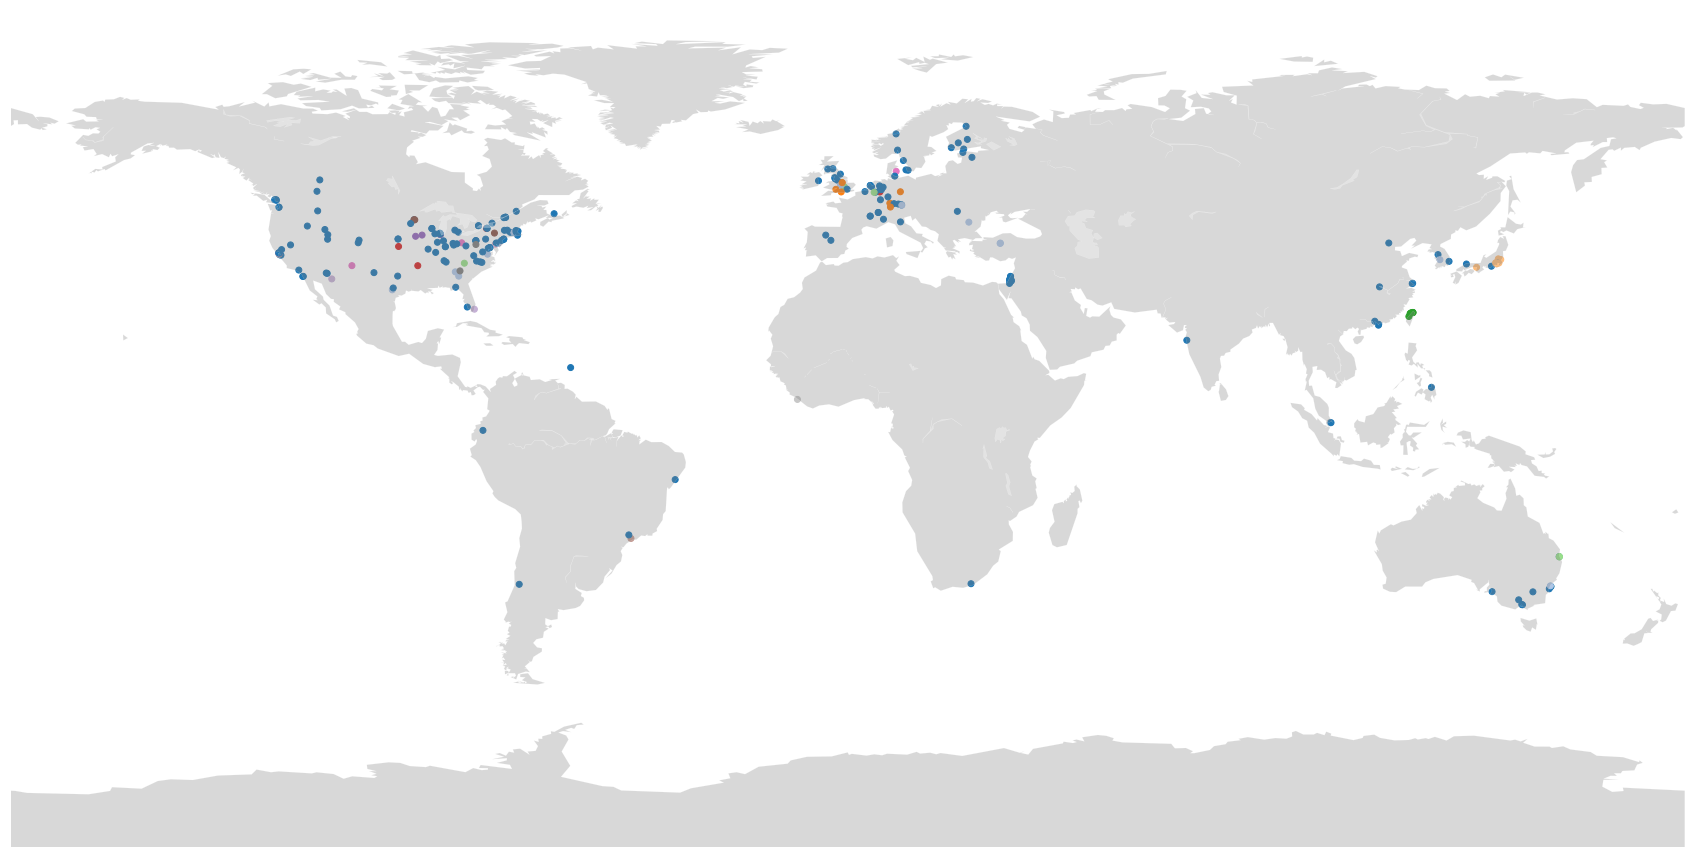

In [69]:
plt.figure(figsize=(30, 20))
m=Basemap()
m.drawmapboundary(linewidth=0)
m.fillcontinents(color='grey', alpha=0.3)
m.drawcoastlines(linewidth=0.1, color="white")
 
# prepare a color for each point depending on the continent.
data = nodes.iloc[list(largest_cc)].copy()
 
# Add a point per position
m.scatter(data['Lon'], data['Lat'], c=pd.Series(uni_partition).sort_index().tolist(), cmap=ListedColormap(palette.as_hex()))


The Universities in each cluster are:

Cluster number:  1


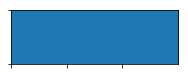

['University of Colorado at Boulder', 'Indiana University at Bloomington', 'Indiana University', 'Technische Universität München', 'Universität Augsburg', 'Ludwig-Maximilians-Universität München', 'University of Edinburgh', 'San Jose State University', 'Harvard University', 'Vanderbilt University', 'University College London, University of London', 'University of Illinois at Chicago', 'University of Toronto', 'Tokyo University', 'Pennsylvania State University', 'New York University', 'Simon Fraser University', 'EPFL - EPF Lausanne', 'Ghent University', 'University of Jyväskylä', 'Swiss Federal Institute for Vocational Education and Training', 'University of Wisconsin - Madison', 'Arizona State University', 'Hebrew University of Jerusalem', 'University of Texas at Austin', 'University of Maryland, College Park', 'University of California, Berkeley', 'Utah State University', 'University of Washington', 'DePaul University', 'Shizuoka University', 'State University of New York at Albany', 

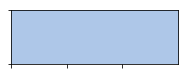

['Georgia State University', 'Virginia Commonwealth University', 'Texas State University', 'Ankara University', 'Middle East Technical University', 'Korea Advanced Institute of Science & Technology', 'Worcester Polytechnic Institute', 'Drexel University', 'University of Warwick', 'Macquarie University', 'Mercer University', 'National University of Singapore', 'University Politehnica of Bucharest', 'Universität der Bundeswehr München, Germany']
Cluster number:  3


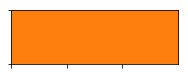

['Knowledge Media Research Center', 'Universität Konstanz', 'Bauhaus Universität Weimar', 'University of Southampton', 'University of the West of England, Bristol', 'McGraw-Hill Education', 'School of Education, University of Nottingham', 'University of Nottingham', 'Google Inc.', 'University of Nottingham, Malaysia Campus', 'Department of Psychology, Durham University', 'Eberhard-Karls-Universität Tübingen', 'Practice for Giftedness and High Achievement Potential', 'Leibniz-Institut für Wissensmedien']
Cluster number:  4


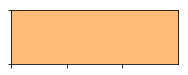

['Soka University', 'Yokohama National University', 'The Open University of Japan', 'Senshu University', 'Kobe University', 'Utsunomiya University', 'Ibaraki University', 'Tokyo Gakugei University']
Cluster number:  5


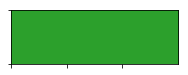

['National Taiwan University of Science and Technology', 'National Taichung University of Science and Technology, Taiwan', 'National Chengchi University', 'National Hsinchu University of Education', 'National Central University', 'National Taiwan Normal University', 'National Tsinghua University']
Cluster number:  6


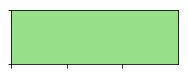

['Griffith University', 'Open University', 'Maastricht University', 'University of Technology Sydney', 'Warren Wilson College', 'Queensland University of Technology', 'James Cook University of North Queensland']
Cluster number:  7


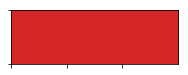

['Universität Köln', 'Kansas State University', 'University of Central Arkansas', 'Rochester Institute of Technology']
Cluster number:  8


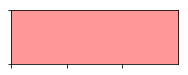

['Central College', 'University of Iowa', 'University of California, Irvine', 'University of Chicago']
Cluster number:  9


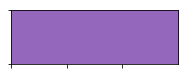

['University of Arizona', 'University of Miami', 'University of Maine System']
Cluster number:  10


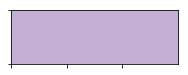

['Minneapolis Institute of Art', 'Science Museum of Minnesota', 'State University of New York at Binghamton']
Cluster number:  11


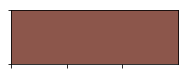

['Educational Testing Service', 'Sony Interactive Entertainment', 'Universidade de São Paulo']
Cluster number:  12


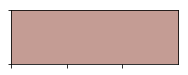

['Ohio State University, Columbus', 'University of Southern Denmark - SDU', 'University of New Mexico']
Cluster number:  13


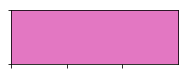

['Temple University', 'University of Delaware']
Cluster number:  14


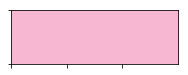

['University of Georgia', 'West Virginia University']
Cluster number:  15


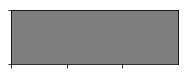

['Ministry of Education', 'Nanyang Technological University']


In [70]:
for i, m in enumerate(list(greedy_modularity_communities(main_universities))):
    unis = nodes.iloc[list(m)]
    unis = unis[unis.name.map(lambda x: True if reg.search('\p{Lu}',x) else False)].name.unique().tolist() 
    if len(unis) > 1:
        print('Cluster number: ', i+1)
        sns.palplot(palette[i])
        plt.show()
        print(unis)

# Looking at co authorship, taking into consideration country and inst.

We use the associations frame again to build a co-authorship graph based on people with attributes country and institution

In [71]:
associations.columns

Index(['file_x', 'name', 'domain', 'mail', 'author_order_x', 'country', 'Lat',
       'Lon', 'merge_index', 'file_y', 'subject', 'iso', 'uri', 'type',
       'publisher', 'title', 'issued', 'accessioned', 'citation', 'available',
       'abstract', 'long_name', 'author_order_y', 'shortend_names',
       'identifier'],
      dtype='object')

In [72]:
#we can drop one of the file columns
(associations.file_x != associations.file_y).sum()

0

In [73]:
associations['file'] = associations['file_x']
del associations['file_y'], associations['file_x']

In [74]:
associations = associations[associations.country.notna()]

In [75]:
self_merge = pd.merge(associations, associations, on='file')
self_merge = self_merge[self_merge.long_name_x != self_merge.long_name_y]

edges = self_merge[['long_name_x', 'long_name_y', 'issued_x']].copy()

nodes = associations[~associations.long_name.duplicated()].reset_index(drop=True).reset_index()

name_index = nodes.long_name.to_dict()
name_index = {v: k for k, v in name_index.items()}

In [76]:
edges['index_x'] = edges.long_name_x.map(name_index)
edges['index_y'] = edges.long_name_y.map(name_index)

adjacency = get_adjacency(nodes, edges)
graph = nx.from_numpy_array(adjacency)

Adding attributes to the graph:

In [77]:
edge_dict = {}
for i, row in edges.iterrows():
    edge_dict[(row['index_x'], row['index_y'])] =  row['issued_x']

In [78]:
nx.set_edge_attributes(graph, edge_dict, name='year')
nx.set_node_attributes(graph, nodes.country.to_dict(), name='country')
nx.set_node_attributes(graph, nodes.name.to_dict(), name='uni')
mapping = nodes.long_name.to_dict()
H=nx.relabel_nodes(graph,mapping)

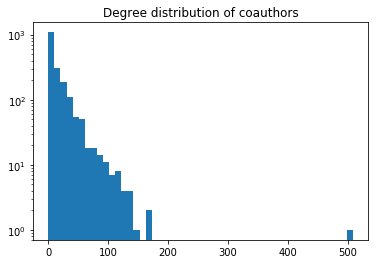

In [79]:
plt.title('Degree distribution of coauthors')
plt.hist(adjacency.sum(axis=1), bins=50, log=True)
plt.show()

This is a simple drawing of our network: we see that there is a large core communit, and many many smaller comminitues of co authors. We will look more into the main community

/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


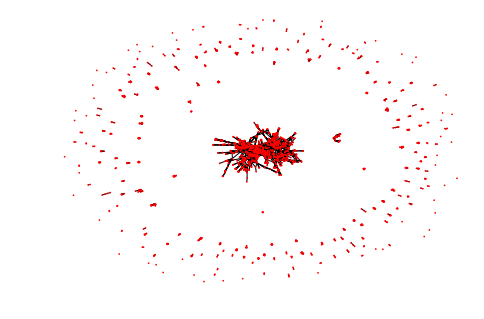

In [80]:
nx.draw(graph, pos=nx.spring_layout(graph), node_size=[0.5,0.5])

In [81]:
embedding = nodes.apply(lambda x: [x.Lon, x.Lat], axis=1)

/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


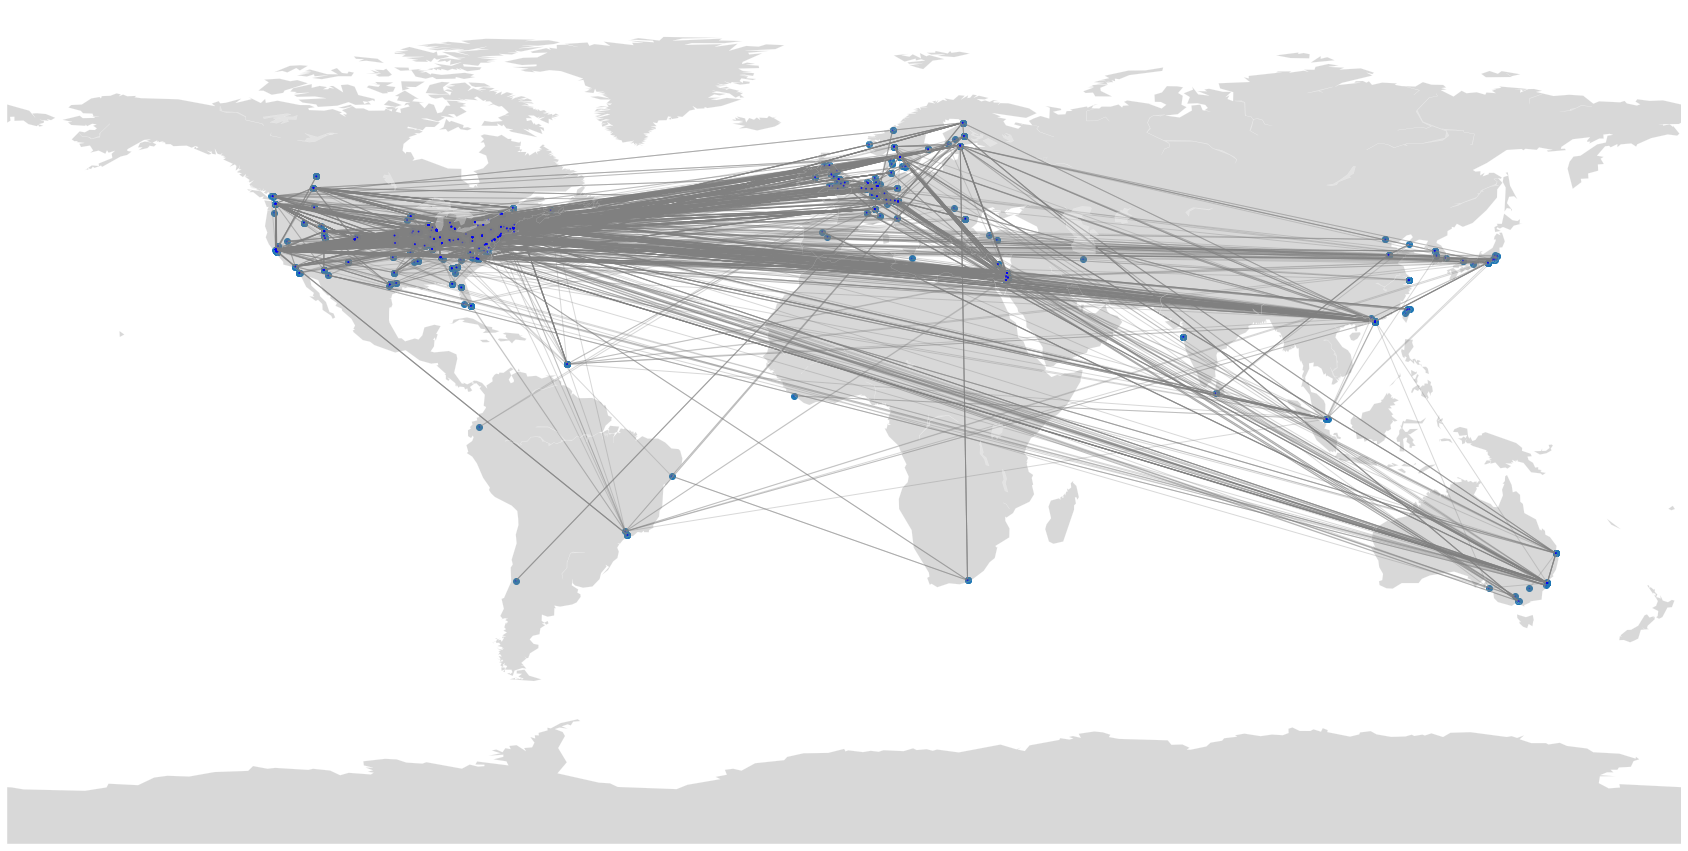

In [82]:

plt.figure(figsize=(30, 20))
m=Basemap()
m.drawmapboundary(linewidth=0)
m.fillcontinents(color='grey', alpha=0.3)
m.drawcoastlines(linewidth=0.1, color="white")
 
# prepare a color for each point depending on the continent.
data = nodes.copy()
 
# Add a point per position
m.scatter(data['Lon'], data['Lat'])
nx.draw(graph, node_size=[0.5,0.5], pos = embedding, edge_color='grey', node_color='b', alpha=0.3)


We focus in on the different components:

In [83]:
#get components
components = nx.connected_components(graph)
largest_cc = max(nx.connected_components(graph), key=len)

The total number of components is:

In [84]:
nx.number_connected_components(graph)

228

In [85]:
print(f'the largest component contains : {len(largest_cc)} people')

the largest component contains : 1164 people


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


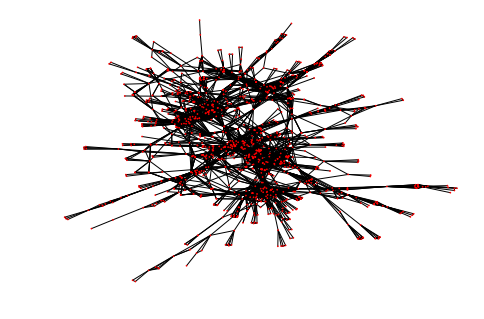

In [86]:
nx.draw(graph.subgraph(largest_cc), node_size=[0.5,0.5])

Drawing it in a geographical embedding:

In [87]:
embedding = nodes.iloc[list(largest_cc)].apply(lambda x: [x.Lon, x.Lat], axis=1)

/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


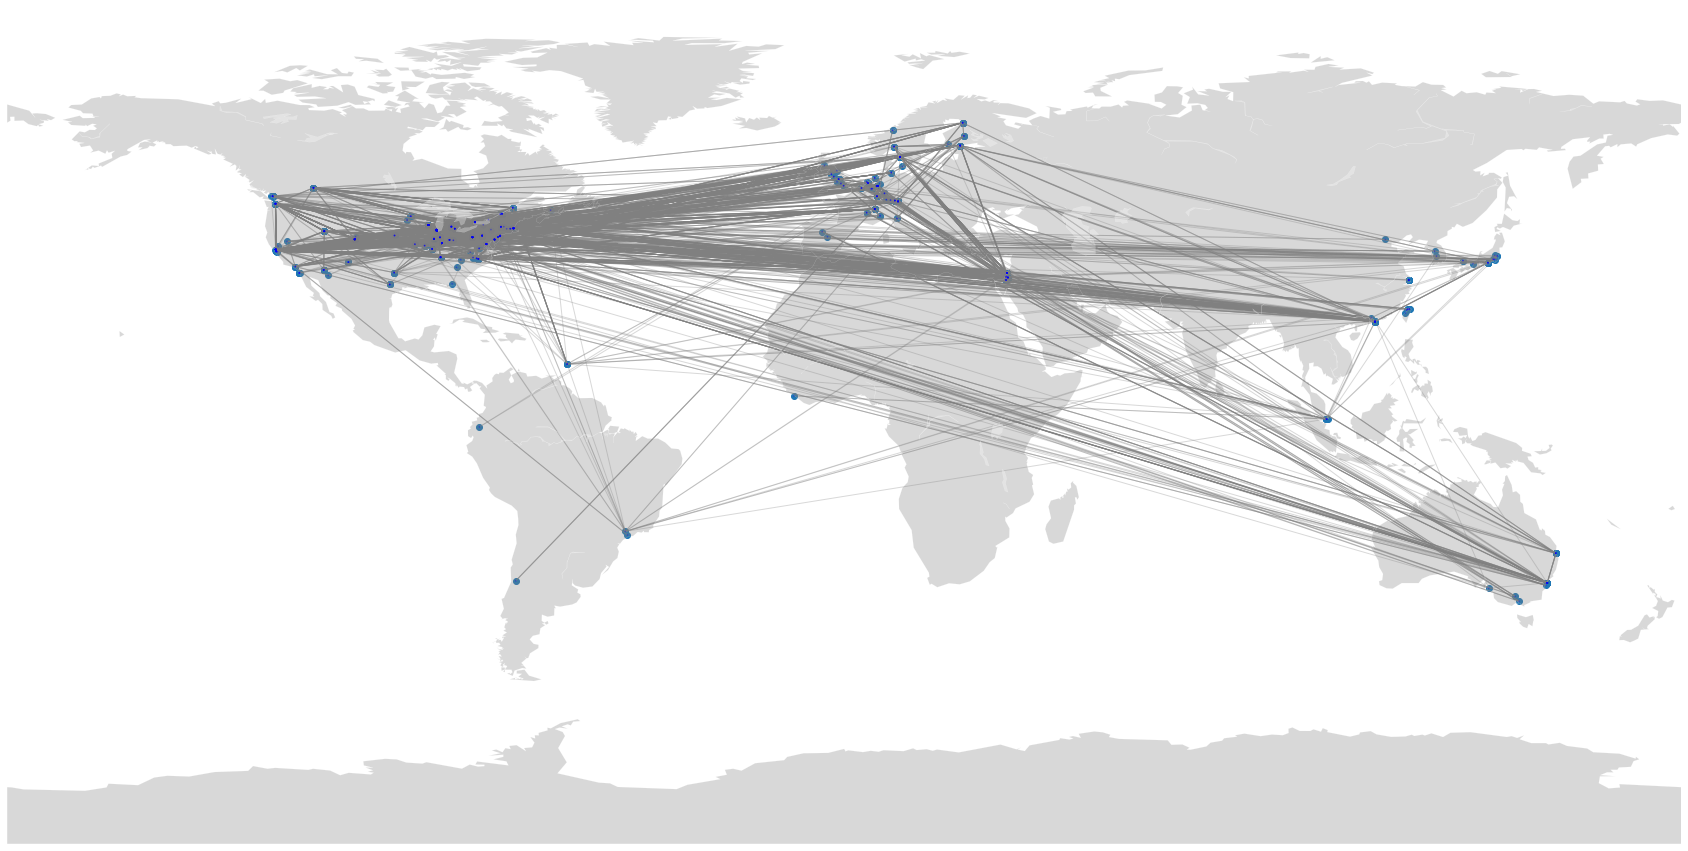

In [88]:
plt.figure(figsize=(30, 20))
m=Basemap()
m.drawmapboundary(linewidth=0)
m.fillcontinents(color='grey', alpha=0.3)
m.drawcoastlines(linewidth=0.1, color="white")
 
# prepare a color for each point depending on the continent.
data = nodes.iloc[list(largest_cc)].copy()
 
# Add a point per position
m.scatter(data['Lon'], data['Lat'])
nx.draw(graph.subgraph(largest_cc), node_size=[0.5,0.5], pos = embedding, edge_color='grey', node_color='b', alpha=0.3)


### Who colaborates the most:

We can easely find the people who worked with the most other people:
(counting repeat collaboration)

In [89]:
nodes['collabs_weighted'] = adjacency.sum(axis=1)
nodes.sort_values(by='collabs_weighted', ascending=False)[['long_name', 'country', 'name', 'collabs_weighted']].head(10)

long_name        country  \
179         Rummel, Nikol        Germany   
38       Slotta, James D.         Canada   
96         Zhang, Jianwei  United States   
1309     Wichmann, Astrid        Germany   
146            Kali, Yael         Sweden   
120        Danish, Joshua  United States   
572          Enyedy, Noel  United States   
97          Chen, Mei-Hwa  United States   
37             Moher, Tom  United States   
424   Dillenbourg, Pierre    Switzerland   

                                        name  collabs_weighted  
179                   Ruhr-University Bochum               508  
38                     University of Toronto               166  
96    State University of New York at Albany               164  
1309                  Ruhr-University Bochum               144  
146                      Göteborg University               138  
120        Indiana University at Bloomington               138  
572    University of California, Los Angeles               136  
97    State University of New York at Albany               134  
37         University of Illinois at Chicago               132  
424                      EPFL - EPF Lausanne               132

Same as above but counting person only once:

In [90]:
nodes['collabs_unweighted'] = np.where(adjacency > 0, 1, 0).sum(axis=1)
nodes.sort_values(by='collabs_unweighted', ascending=False)[['long_name', 'country', 'name', 'collabs_unweighted']].head(10)

long_name        country                                    name  \
146         Kali, Yael         Sweden                     Göteborg University   
179      Rummel, Nikol        Germany                  Ruhr-University Bochum   
38    Slotta, James D.         Canada                   University of Toronto   
96      Zhang, Jianwei  United States  State University of New York at Albany   
39       Acosta, Alisa         Canada                   University of Toronto   
97       Chen, Mei-Hwa  United States  State University of New York at Albany   
630        Bang, Megan  United States                University of Washington   
80        Bell, Philip  United States                University of Washington   
940        Kidron, Adi  United States      University of California, Berkeley   
1064        Horn, Mike  United States                 Northwestern University   

      collabs_unweighted  
146                   65  
179                   62  
38                    60  
96                    58  
39                    55  
97                    53  
630                   53  
80                    47  
940                   46  
1064                  46

### Zooming into largest community: - country & institution

In [91]:
main_component = nodes[nodes.index.isin(largest_cc)]

Comparing the country representation in main component to the one overall.

Text(0, 0.5, 'Counts')

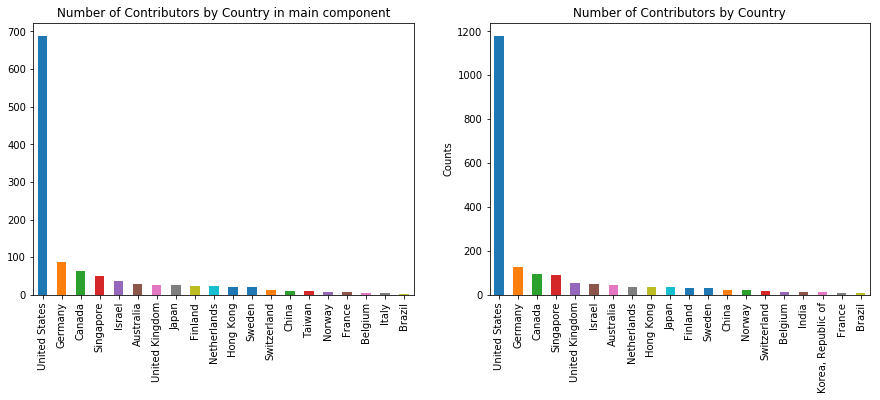

In [92]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.title('Number of Contributors by Country in main component')
main_component.country.value_counts().head(20).plot(kind='bar')
plt.subplot(122)
universities[(~universities.mail.duplicated())].country.value_counts().head(20).plot(kind = 'bar')
plt.title('Number of Contributors by Country') # as determinded by university affiliation
plt.ylabel('Counts')

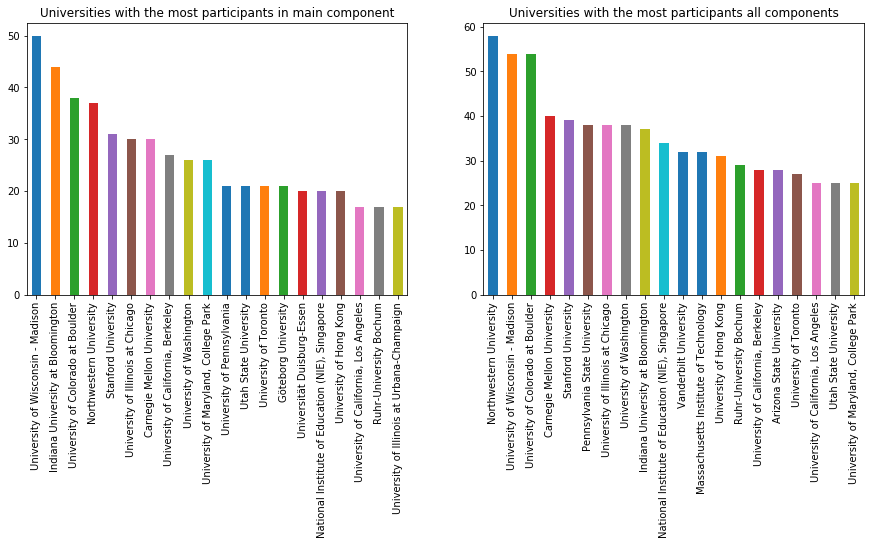

In [93]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
#plt.ylim([0, 60])
plt.title('Universities with the most participants in main component')
main_component.name.value_counts().head(20).plot(kind='bar')
plt.subplot(122)
#plt.ylim([0, 60])
plt.title('Universities with the most participants all components')
universities[(universities.name != 'gmail') & (~universities.mail.duplicated())].name.value_counts().head(20).plot(kind='bar')
plt.show()

## Finding communities in the community: Modularity and Other measures

Constructing the graph with the largest component:

In [94]:
main_component = graph.subgraph(largest_cc)
mapping = nodes.long_name.to_dict()
main_component=nx.relabel_nodes(main_component,mapping)

Here we use modularity to detect communities, which will find subgraph that are unliquely to have developed "randomly".

From wikipedia:

>It was designed to measure the strength of division of a network into modules (also called groups, clusters or communities). Networks with high modularity have dense connections between the nodes within modules but sparse connections between nodes in different modules. Modularity is often used in optimization methods for detecting community structure in networks

In [95]:
c = list(greedy_modularity_communities(main_component))

We find 18 communities in total:

In [96]:
len(c)

18

In [97]:
#smallest community:
min(c, key=len)

frozenset({'Quignard, Matthieu', 'Tchounikine, Pierre', 'Wang, Patrick'})

## Intermezzo: removing duplicate names!

We could use this to elliminate duplicates, merge some people:

The difficulty is to not have any false positives. False negatives are fine, We thus decide to look at similar names **within** the communities we found. Additionaly we check that the same last name is present and exclude some last names (chinese ones) as they are prone to lead to false positives.

In [98]:
#example of duplicates showing up!
metadata[metadata.long_name.isin(['Cuendet, Sebastien', 'Cuendet, Sébastien'])]

file                                            subject  \
1656    import2016full_68                                                NaN   
1742   import2015full_182  ['tangible user interface', 'eye-tracking', 'j...   
1862  import2015short_182  ['tangible user interface', 'eye-tracking', 'j...   

     iso                                       uri          type  \
1656  en             info:doi/10.22318/icls2016.68  Book chapter   
1742  en  https://doi.dx.org/10.22318/cscl2015.182  Book chapter   
1862  en  https://doi.dx.org/10.22318/cscl2015.182  Book chapter   

                                              publisher  \
1656  Singapore: International Society of the Learni...   
1742   International Society of the Learning Science...   
1862   International Society of the Learning Science...   

                                                  title  issued  \
1656  Detecting Collaborative Dynamics Using Mobile ...    2016   
1742  3D Tangibles Facilitate Joint Visual Attention...    2015   
1862  3D Tangibles Facilitate Joint Visual Attention...    2015   

             accessioned                                           citation  \
1656 2017-03-21 12:05:42  Schneider, B., Sharma, K., Cuendet, S., Zuffer...   
1742 2017-06-19 14:15:51  Schneider, B., Sharma, K., Cuendet, S., Zuffer...   
1862 2017-06-19 14:15:51  Schneider, B., Sharma, K., Cuendet, S., Zuffer...   

               available                                           abstract  \
1656 2017-03-21 12:05:42  Prior work has successfully described how low ...   
1742 2017-06-19 14:15:51  We report results from a dual eye-tracking stu...   
1862 2017-06-19 14:15:51  We report results from a dual eye-tracking stu...   

                long_name  author_order shortend_names  \
1656   Cuendet, Sebastien             2      Sharma K.   
1742  Cuendet, Sébastien             2      Sharma K.   
1862  Cuendet, Sébastien             2      Sharma K.   

                                             identifier           merge_index  
1656  Schneider, B., Sharma, K., Cuendet, S., Zuffer...    import2016full_682  
1742  Schneider, B., Sharma, K., Cuendet, S., Zuffer...   import2015full_1822  
1862  Schneider, B., Sharma, K., Cuendet, S., Zuffer...  import2015short_1822

Number of members before uniformisation:

In [99]:
import difflib


def find_name_matching(c, threshold = 0.7, last_names_to_ignore = ['zhang', 'chen']):
    """finds different spellings of same name and gives mapping to create one person one name"""
    d = {}
    for community in c:
        members = list(community)
        for i, member in enumerate(members):
            for j, member_2 in enumerate(members):
                if i < j:
                    difference = difflib.SequenceMatcher(None, member, member_2).ratio()
                    if difference > threshold:
                        last_1 =reg.search('[\p{L}ä]*', member.lower()).group(0)
                        last_2 = reg.search('[\p{L}ä]*', member_2.lower()).group(0)
                        same_last_name = reg.search('[\p{L}ä]*', member.lower()).group(0) == reg.search('[\p{L}ä]*', member_2.lower()).group(0)
                        if same_last_name and last_1 not in last_names_to_ignore  and not member_2 in d.keys():
                            d[member_2] = member
    return d

d = find_name_matching(c)
len(d)

68

In [100]:
ord(u'ä')

228

In [101]:
for c in u"ä":
    print(repr(c), ord(c))

'a' 97
'̈' 776


In [102]:
#mapping unifying the different but same names
d

{'Applebaum, Lauren': 'Applebaum, Lauren R.',
 'Azevedo, Flávio S.': 'Azevedo, Flavio S.',
 'Bell, Adam': 'Bell, Amanda M',
 'Brami, Uzi': 'Brami, Uzi Zevik',
 'Brown, David': 'Brown, David E.',
 'Champion, Dionne N.': 'Champion, Dionne',
 'Chan, Carol': 'Chan, Carol K. K.',
 'Chan, Carol K.K.': 'Chan, Carol K. K.',
 'Clegg, Tamara L.': 'Clegg, Tamara',
 'Cuendet, Sebastien': 'Cuendet, Sébastien',
 'Danish, Joshua': 'Danish, Joshua A.',
 'Dornfeld, Catherine L.': 'Dornfeld, Catherine',
 'D’Angelo, Sarah': "D'Angelo, Sarah",
 'Eagan, Brendan R': 'Eagan, Brendan R.',
 'Flood, Virginia J.': 'Flood, Virginia J',
 'Froehlich, Jon': 'Froehlich, Jon E.',
 'Gomoll, Andrea Sarah': 'Gomoll, Andrea S.',
 'Graville-Smith, Cynthia': 'Graville, Cynthia Story',
 'Greenhow, Christine': 'Greenhow, Chrisine',
 'Halverson, Erica': 'Halverson, Richard',
 'Harrer, Benedikt Walter': 'Harrer, Benedikt W.',
 'Hickey, Daniel': 'Hickey, Daniel T.',
 'Horn, Mike': 'Horn, Michael',
 'Jacobson, Michael': 'Jacobso

In [103]:
improved_associations = associations.copy()

In [104]:
improved_associations.loc[improved_associations.long_name.map(d).notna(), 'long_name'] = improved_associations.long_name.map(d)

In [105]:
self_merge = pd.merge(improved_associations, improved_associations, on='file')
self_merge = self_merge[self_merge.long_name_x != self_merge.long_name_y]

edges = self_merge[['long_name_x', 'long_name_y', 'issued_x']].copy()

nodes = improved_associations[~improved_associations.long_name.duplicated()].reset_index(drop=True).reset_index()

name_index = nodes.long_name.to_dict()
name_index = {v: k for k, v in name_index.items()}

edges['index_x'] = edges.long_name_x.map(name_index)
edges['index_y'] = edges.long_name_y.map(name_index)


new_graph = nx.from_numpy_array(get_adjacency(nodes, edges))


components = nx.connected_components(new_graph)
largest_cc = max(nx.connected_components(new_graph), key=len)

In [106]:
main_component = new_graph.subgraph(largest_cc)
mapping = nodes.long_name.to_dict()
#main_component=nx.relabel_nodes(main_component,mapping)

## clique detection:


Here we look at large groups of researchers that all have collaborated within eachother.
We look at groups of at least 15 people:

In [107]:
main_component_ =nx.relabel_nodes(main_component, mapping)
large_cliques = [l for l in list(nx.find_cliques(main_component_)) if len(l) > 15]

In [108]:
large_cliques[0]

['Severance, Samuel',
 'Van Horne, Katie',
 'Penuel, William R.',
 'Zaidi, Sania Zahra',
 'Furtak, Erin Marie',
 'Chattergoon, Rajendra',
 'Neumann, Knut',
 'Gane, Brian Douglas',
 'Pellegrino, James W',
 'Fortus, David',
 'Wingert, Kerri',
 'Briggs, Derek',
 'Pennock, Phyllis Haugabook',
 'Harris, Christopher J.',
 'Krajcik, Joe',
 'Nordine, Jeffrey']

We get a total of 12 groups:

In [109]:
len(large_cliques)

12

In [110]:
large_cliques = [l for l in list(nx.find_cliques(main_component)) if len(l) > 13]
color_cliques = {}
set_inclique = set()
for i, clique in enumerate(large_cliques):
    for member in clique:
        color_cliques[member] = i+1
        set_inclique.add(member)

In [111]:
for member in (set(nodes.iloc[list(largest_cc)].index.tolist())-set_inclique):
    color_cliques[member] = 0

Define colormap for better plotting:

   1  ||  2  ||  3  ||  4  ||  5  ||  6  ||  7  ||  8  ||  9  ||  10  ||  11  ||  12  ||  13  ||  14  ||  15


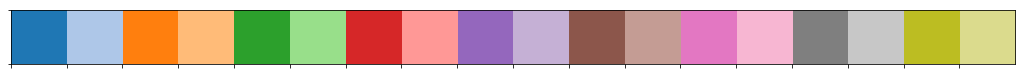

In [112]:
palette = sns.color_palette(palette='tab20', n_colors=len(large_cliques)+1)

sns.palplot(palette)
print('  ', '  ||  '.join([str(i) for i in list(range(1,len(partition)+1))]))

/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


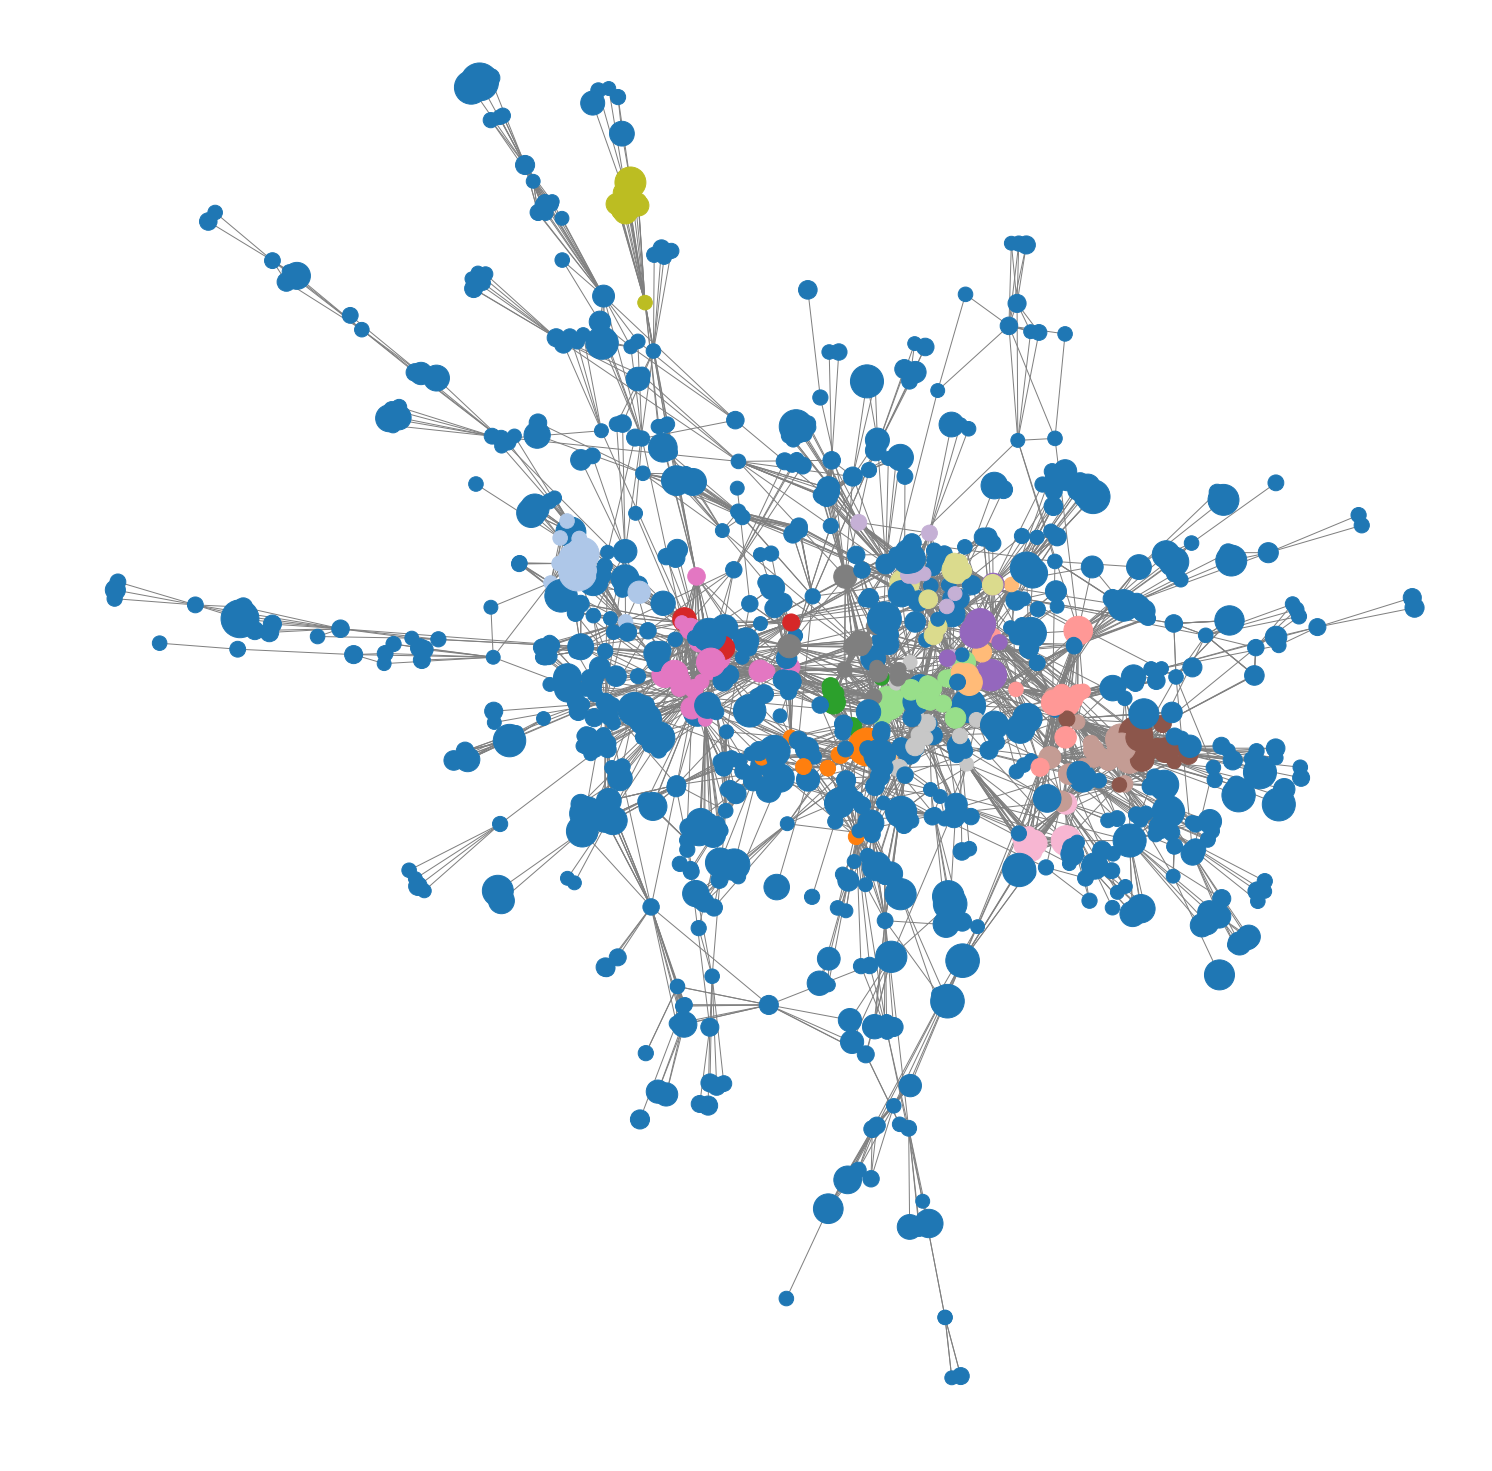

In [113]:
plt.figure(figsize=(20, 20))
nx.draw_spring(main_component, node_color=pd.Series(color_cliques).sort_index().tolist(), 
              cmap=ListedColormap(palette.as_hex()),
              node_size=(node_size+node_size.mean())*6000,
               edge_color='grey',
               iterations=400
              )

In [114]:
color = {}
for i, clique in enumerate(large_cliques):
    for member in clique:
        color[member] = i+2

/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


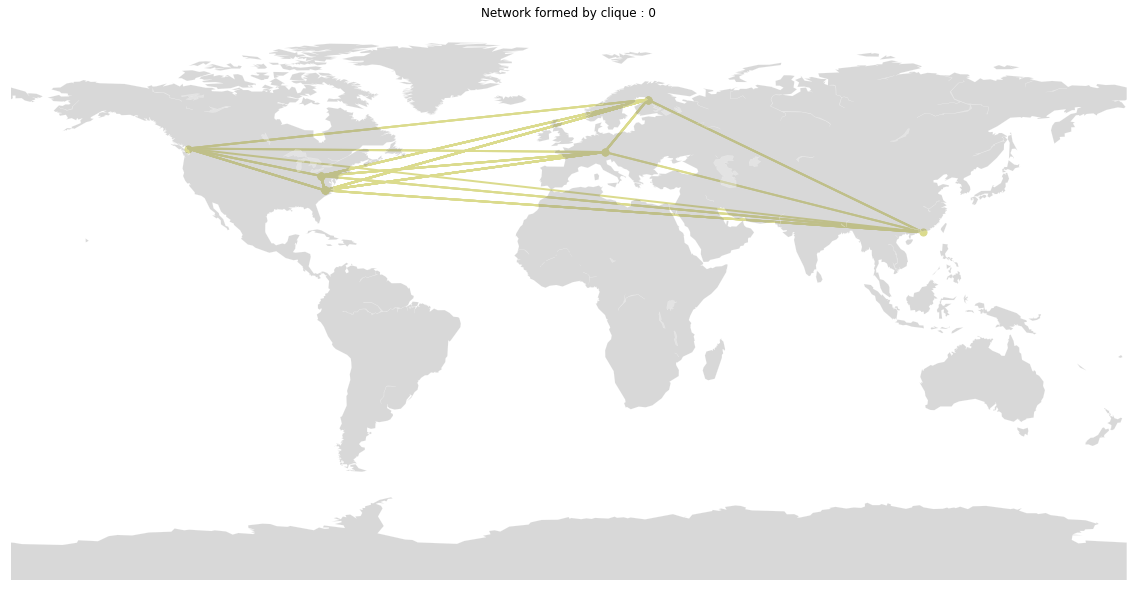

['Fischer, Frank', 'Stegmann, Karsten', 'Järvelä, Sanna', 'Wen, Miaomiao', 'Wise, Alyssa Friend', 'Martin, Seth A.', 'Yang, Diyi', 'Malmberg, Jonna', 'Järvenoja, Hanna', 'Azevedo, Roger', 'Mudrick, Nicholas', 'Taub, Michelle', 'Rosé, Carolyn Penstein', 'Farnsworth, Jesse', 'Mu, Jin']


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


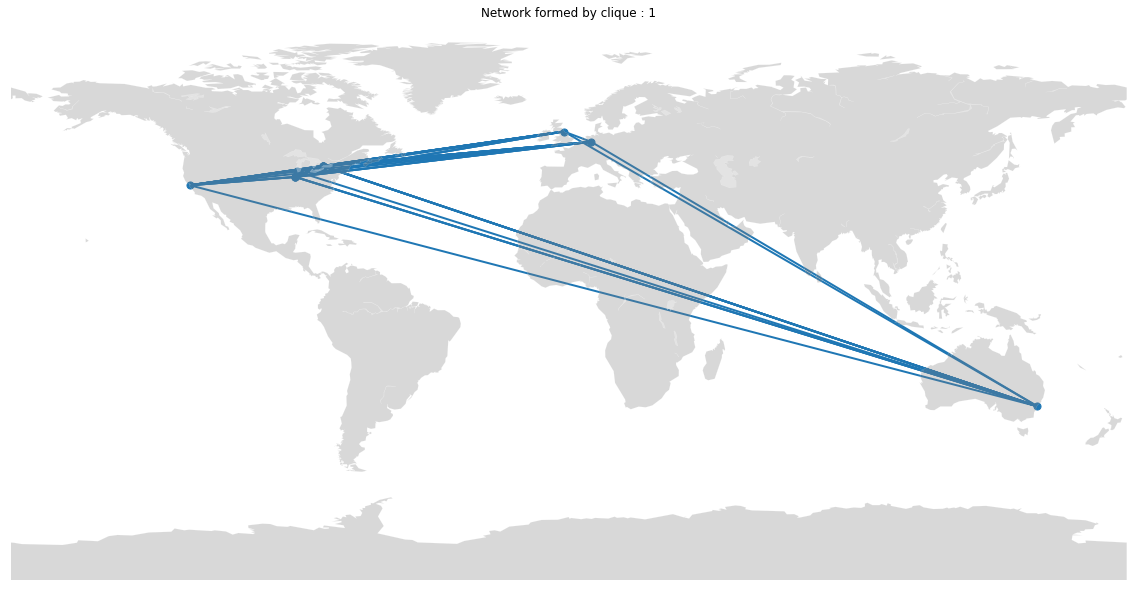

['Slotta, James', 'Israel, Maya', 'Shehab, Saadeddine', 'Joyce-Gibbons, Andrew', 'Mercier, Emma', 'Moher, Tom', 'Cober, Rebecca', 'Fong, Cresencia', 'Rummel, Nikol', 'Messina, Richard', 'Forssell, Karin S.', 'Martinez-Maldonado, Roberto', 'Murray, Julia', 'Peebles, Ben']


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


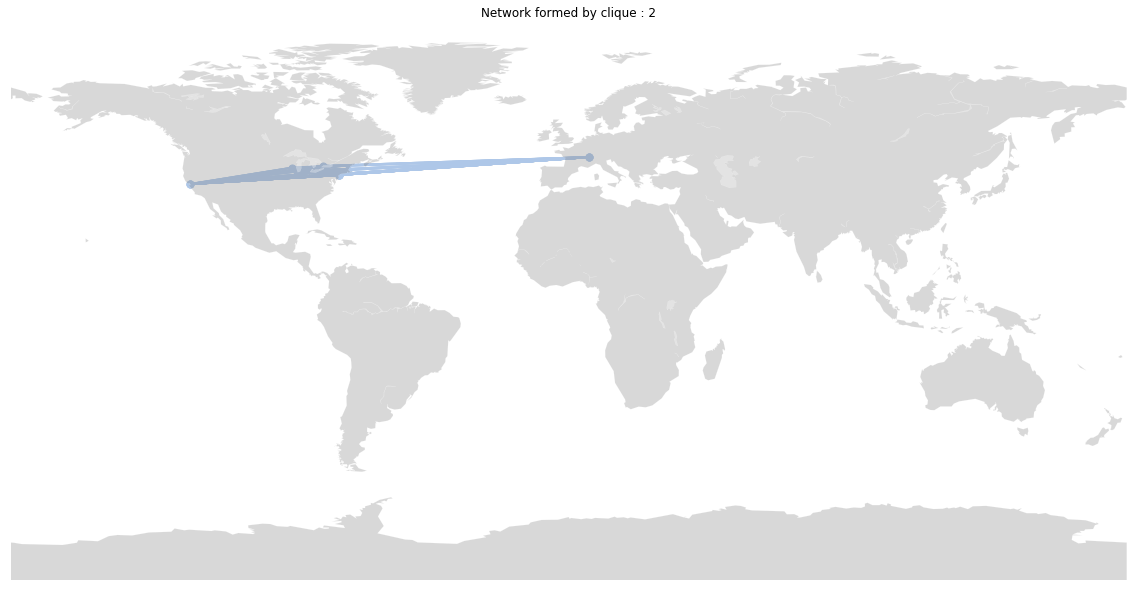

['Slotta, James', 'Dillenbourg, Pierre', 'Tissenbaum, Mike', 'Berland, Matthew', 'Lyons, Leila', 'Vitale, Jonathan M.', 'Cocco, Felipe', 'Plass, Jan L.', 'Matuk, Camillia', 'Hajny, Nik', 'Linn, Marcia C.', 'Gerard, Libby', 'Olsen, Al', 'Schwendimann, Beat', 'Boroujeni, Mina Shirvani']


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


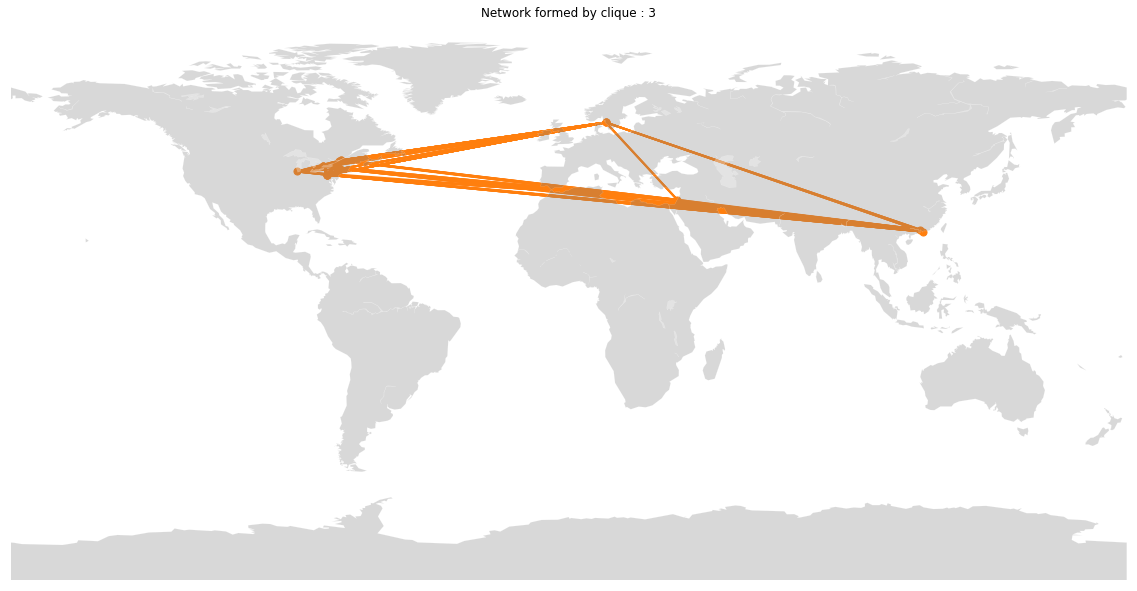

['Slotta, James', 'Acosta, Alisa', 'Kali, Yael', 'Zhang, Jianwei', 'Chen, Mei-Hwa', 'Moher, Tom', 'Hod, Yotam', 'Charles, Elizabeth S.', 'Ben-Zvi, Dani', 'Choi, Koun', 'Dugdale, Michael', 'Lenton, Kevin', 'McDonald, Scott P.', 'Quintana, Rebecca M.', 'Rook, Michael M.', 'Tietjen, Phil', 'Weiss, Patrice L. Tamar', 'Whittaker, Chris', 'Bielaczyc, Katerine', 'Kapur, Manu']


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


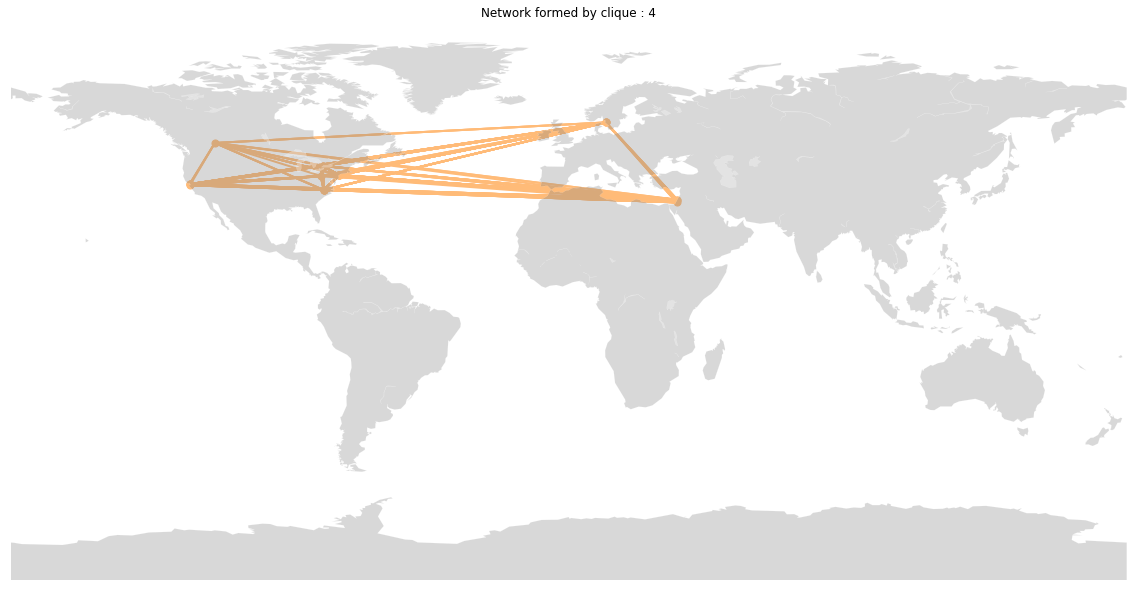

['Slotta, James', 'Acosta, Alisa', 'Kali, Yael', 'Tal, Tali', 'Kidron, Adi', 'Eylon, Bat-Sheva', 'Toutkoushian, Emily', 'Ryoo, Kihyun “Kelly”', 'Bedell, Kristin Dana Bedell', 'Hovey, Christopher M', 'Matuk, Camillia', 'Linn, Marcia C.', 'Hurwich, Talia A', 'Sagy, Ornit', 'Swearingen, Amanda', 'Gerard, Libby', 'Clark, Doug', 'Adams, Deanne', 'Virk, Satyugjit', 'Barnes, Jackie', 'Sarmiento, Juan Pablo', 'Ben-Horin, Hava', 'Chiu, Jennifer', 'Bywater, Jim P', 'Hong, James', 'Osborne, Jonathan', 'Laurillard, Dianna']


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


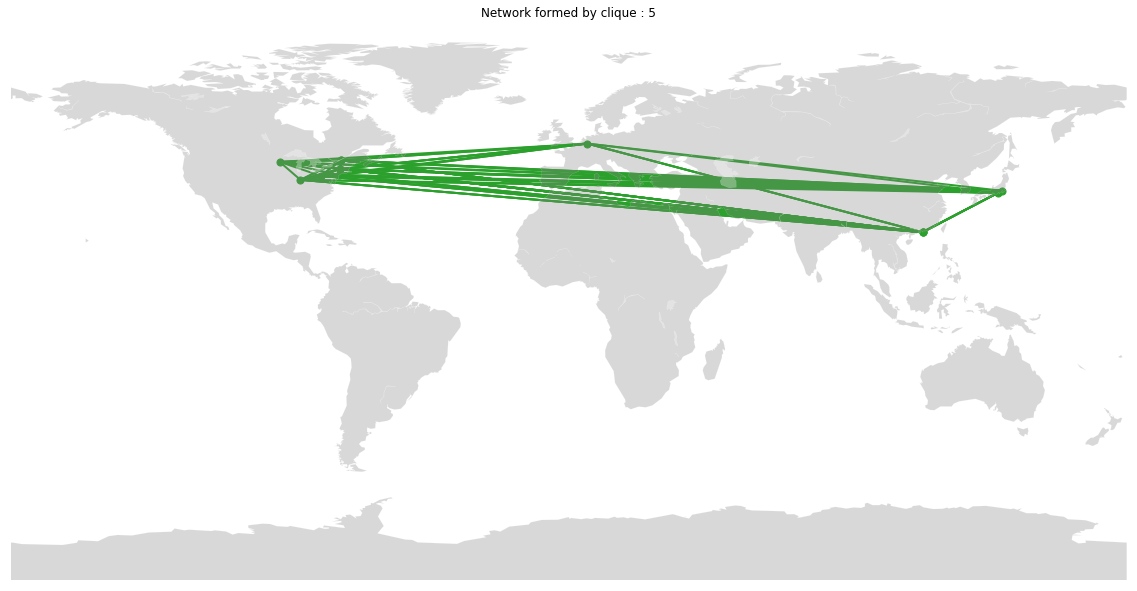

['Wise, Alyssa', 'Matsuzawa, Yoshiaki', 'van den Ende, Joan', 'Zhang, Jianwei', 'Chen, Feng', 'Chen, Mei-Hwa', 'Godinez, Erick Velazquez', 'Ratté, Sylvie', 'Rosé, Carolyn P.', 'Yang, Christine', 'Chen, Bodong', 'Hmelo-Silver, Cindy', 'Chan, Carol K. K.', 'van Aalst, Jan', 'de Jong, Frank', 'Oshima, Jun', 'van Heijst, Hennie', 'Kirschner, Paul A.']


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


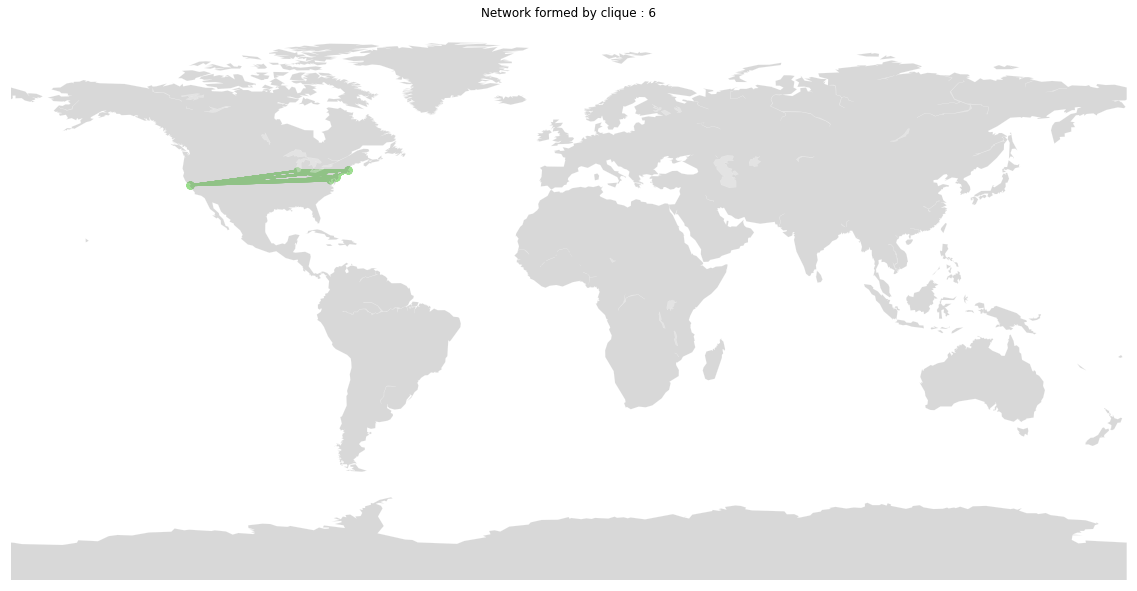

['Shapiro, R. Benjamin', 'Rutstein, Daisy', 'Snow, Eric', 'Shear, Linda', 'Lee, Irene', 'Grover, Shuchi', 'Tissenbaum, Mike', 'Mustafaraj, Eni', 'Klopfer, Eric', 'Temple, Will', 'Sorensen, Clara', 'Horn, Michael', 'Lui, Debora', 'Jayathirtha, Gayithri', 'Basu, Satabdi', 'Sherman, Mark A', 'Sheldon, Joshua', 'Shaw, Mia', 'Abelson, Hal', 'Jona, Kemi', 'Weintrop, David', 'kafai, yasmin', 'Wilensky, Uri']


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


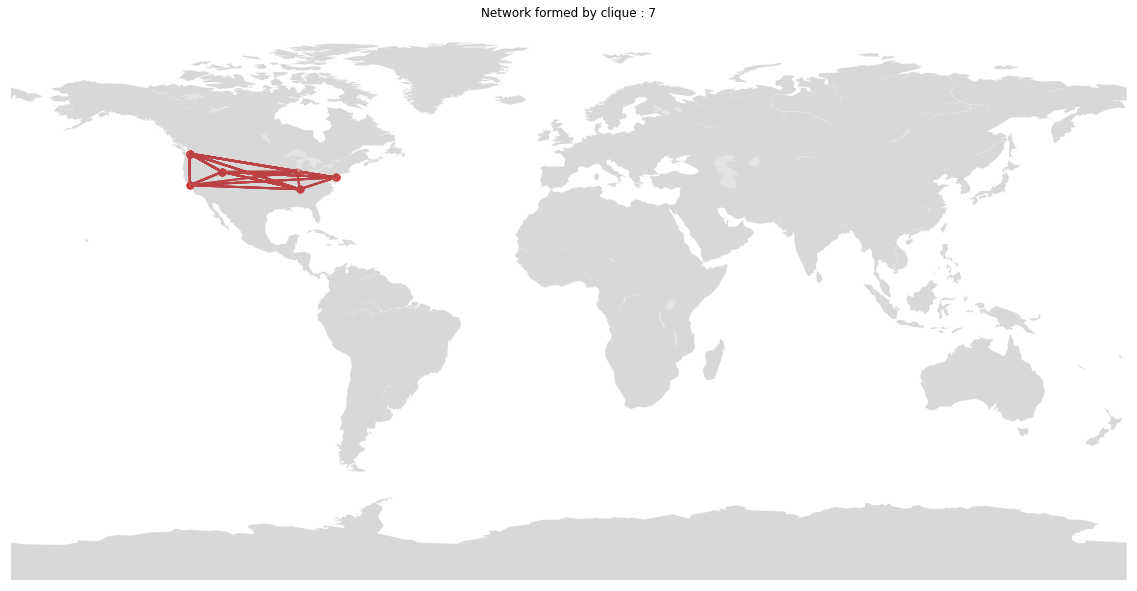

['Lee, Victor R.', 'Bell, Philip', 'Price, Nancy', 'Telhan, Orkan', 'Stromholt, Shelley', 'Bang, Megan', 'kafai, yasmin', 'Hall, Rogers', 'Tzou, Carrie', 'Ng, Meixi', 'Davis, Richard', 'Adleberg, Barrie', 'Kahn, Jennifer', 'Phillips, Abigail Leigh', 'Barron, Brigid', 'Hansen, Jennifer', 'Recker, Mimi']


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


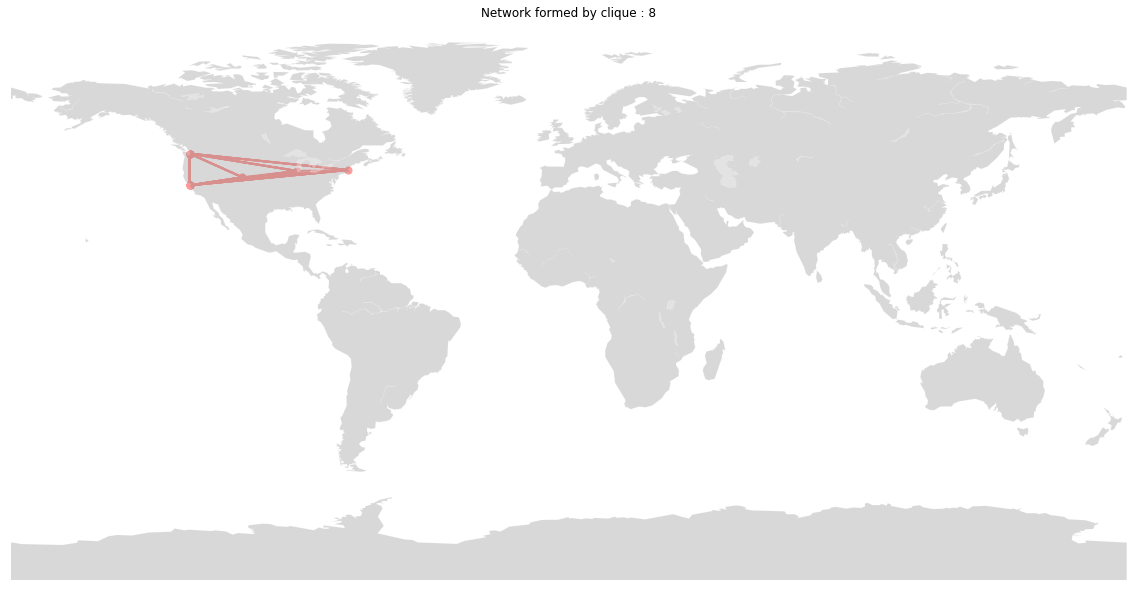

['Bell, Philip', 'Bang, Megan', 'Tzou, Carrie', 'Barron, Brigid', 'Roque, Ricarose', 'Suárez, Enrique', '*, Meixi', 'Pinkard, Nichole', 'McDermott, Raymond', 'Goldman, Shelley', 'Luce, Megan', 'Vea, Tanner', 'Conlin, Luke', 'Martin, Caitlin Kennedy']


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


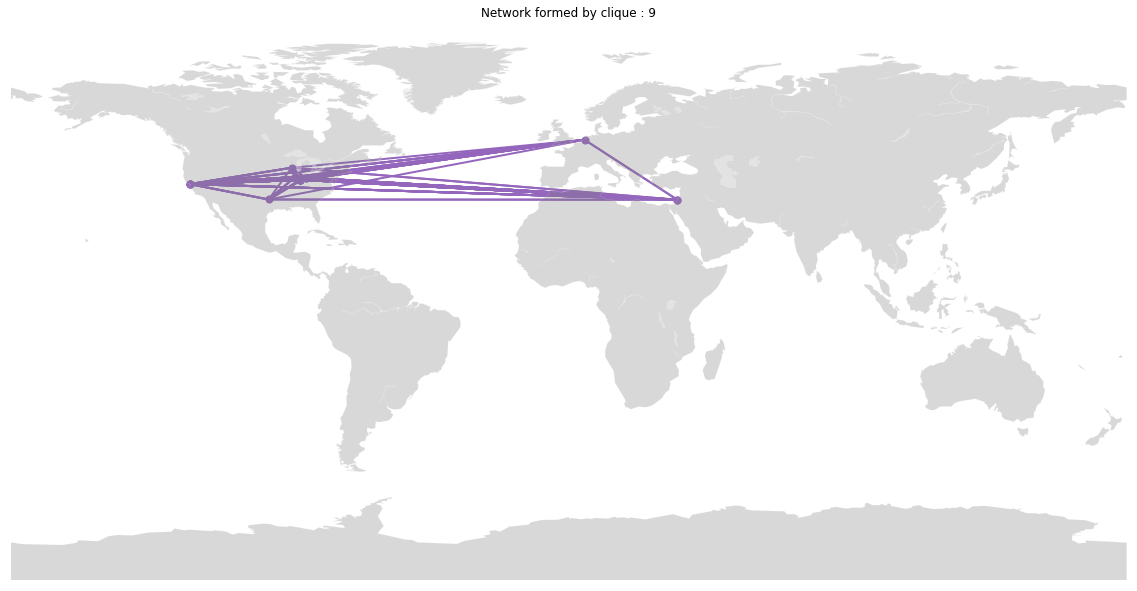

['Georgen, Chris', 'Humburg, Megan', 'Enyedy, Noel', 'Tu, Xintian', 'Davis, Bria', 'Danish, Joshua A.', 'Brown, David E.', 'Abrahamson, Dor', 'Lee, Christine', 'Andrade, Alejandro', 'Maltese, Adam', 'Levy, Sharona', 'Bakker, Arthur', 'Saleh, Asmalina', 'Lindwall, Oskar', 'Nathan, Mitchell', 'Walkington, Candace A', 'Zohar, Asnat R.', 'Lindgren, Robb', 'Dahn, Maggie']


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


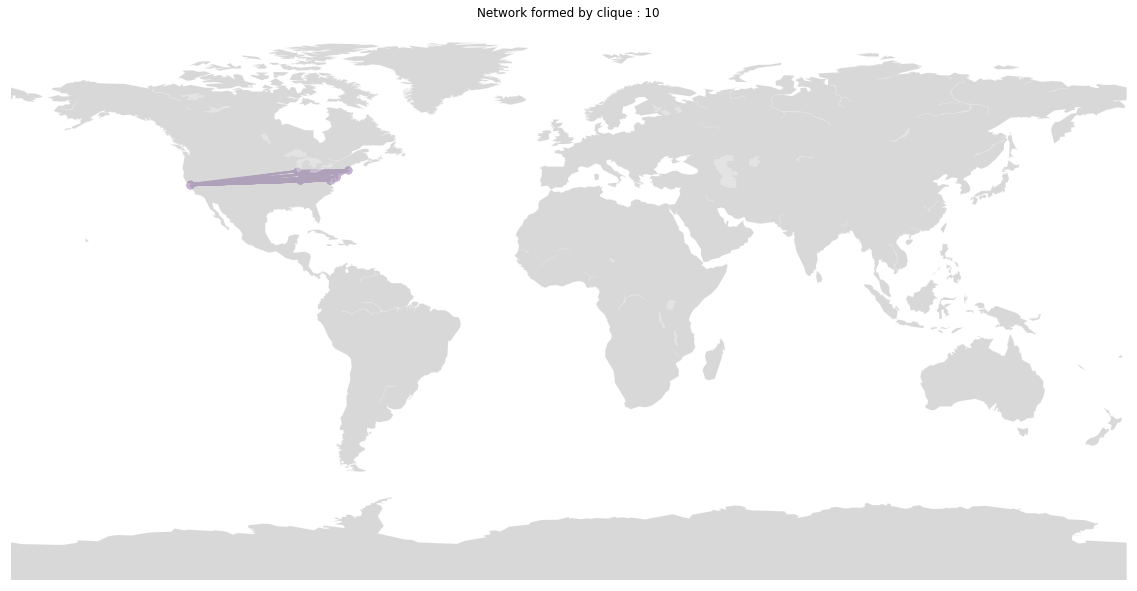

['Georgen, Chris', 'Humburg, Megan', 'Enyedy, Noel', 'Tu, Xintian', 'Davis, Bria', 'Danish, Joshua A.', 'Horn, Michael', 'Froehlich, Jon E.', 'Clegg, Tamara', 'Walker, Justice Toshiba', 'Washington, Peter', 'Riedel-Kruse, Ingmar', 'Lui, Debora', 'kafai, yasmin', 'Bumbacher, Engin', 'Anderson, Emma', 'Norooz, Leyla', 'Byrne, Virginia L', 'Kang, Seokbin', 'Blikstein, Paulo']


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


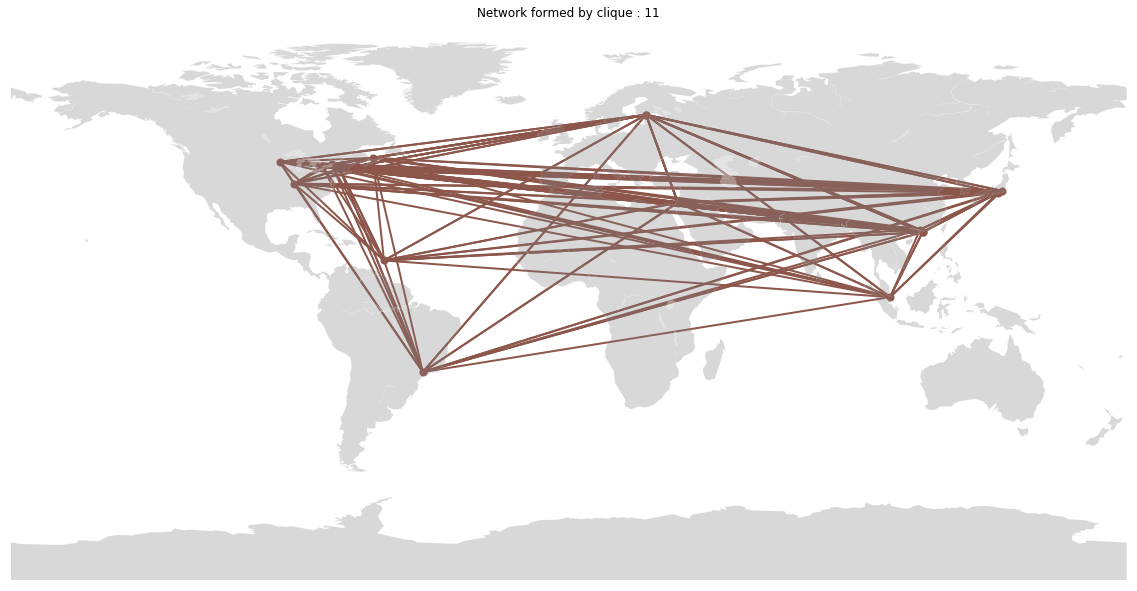

['Oshima, Jun', 'Matsuzawa, Yoshiaki', 'Chen, Bodong', 'van Aalst, Jan', 'Chan, Carol K. K.', 'de Jong, Frank', 'Zhang, Jianwei', 'Chen, Mei-Hwa', 'Scardamalia, Marlene', 'Shirouzu, Hajime', 'Tan, Seng Chee', 'Seitamaa-Hakkarainen, Pirita', 'Vinha, Telma', 'Hakkarainen, Kai', 'Laferrière, Thérèse', 'Reeve, Richard', 'Teo, Chew Lee', 'Bielaczyc, Katerine', 'del Castillo, Fernando Diaz', 'McAuley, Alexander', 'Montané, Mireia', 'Nunes, Cesar']


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


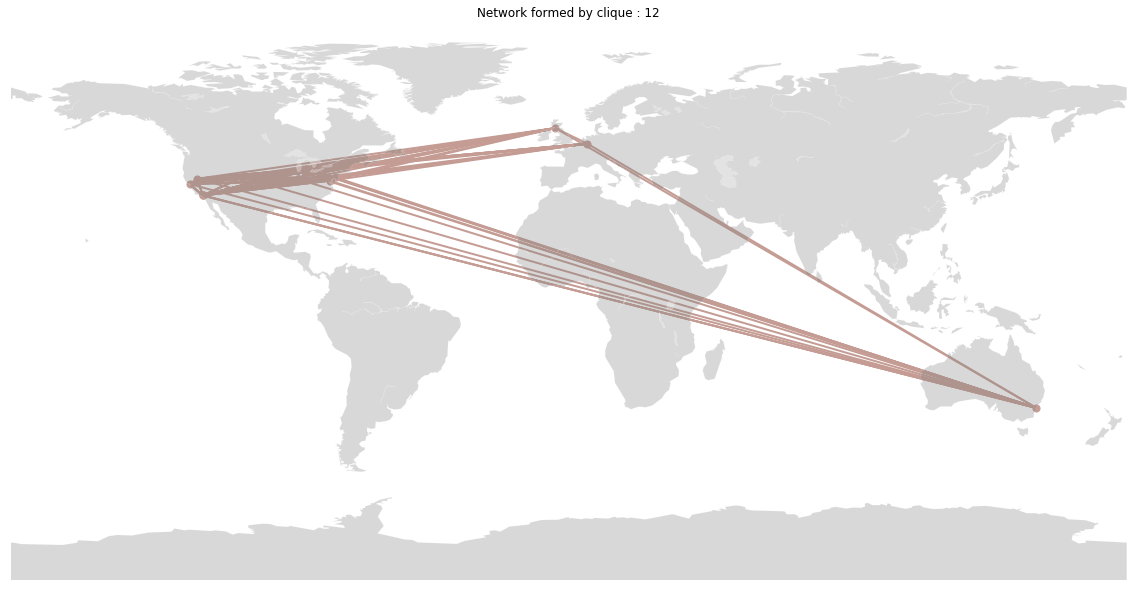

['Yoon, Susan', 'Santo, Rafi', 'Penuel, William R.', 'Anderson, Charles W', 'Baker-Doyle, Kira J', 'de Laat, Maarten', 'de los Santos, Elizabeth Xeng', 'Frank, Kenneth A.', 'Hopkins, Megan', 'Lin, Qinyun', 'Marshall, Stefanie Marshall', 'Miller, Katie A', 'Nijland, Femke', 'Shirrell, Matthew', 'Schreurs, Bieke', 'Spillane, James', 'van Amersfoort, Daniël', 'Whitfield, Latricia Chanel Whitfield']


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


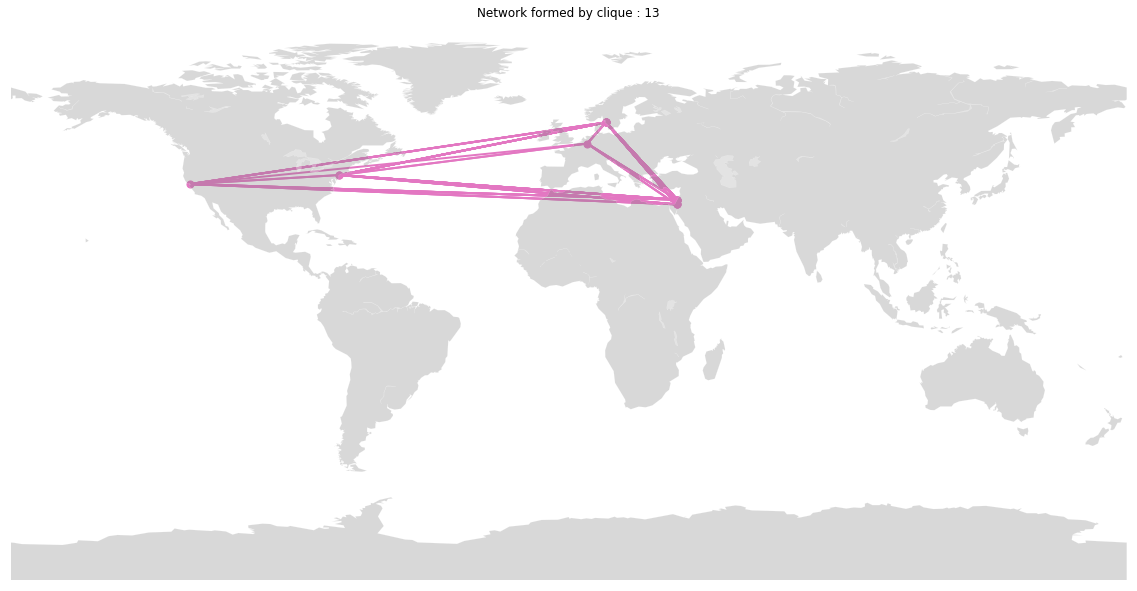

['Brami, Uzi Zevik', 'Tabak, Iris', 'Hoadley, Christopher', 'Amzalag, Meital', 'Duek, Oshra', 'Baram-Tsabari, Ayelet', 'Elias, Nelly', 'Kent, Carmel', 'Laslo, Esther', 'Levy, Keren S.', 'Rafaeli, Sheizaf', 'Ben-Zvi, Dani', 'Kidron, Adi', 'Kali, Yael', 'Weiss, Patrice L. Tamar', 'Tal, Tali', 'Barzilai, Sarit', 'Kirschner, Paul A.']


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


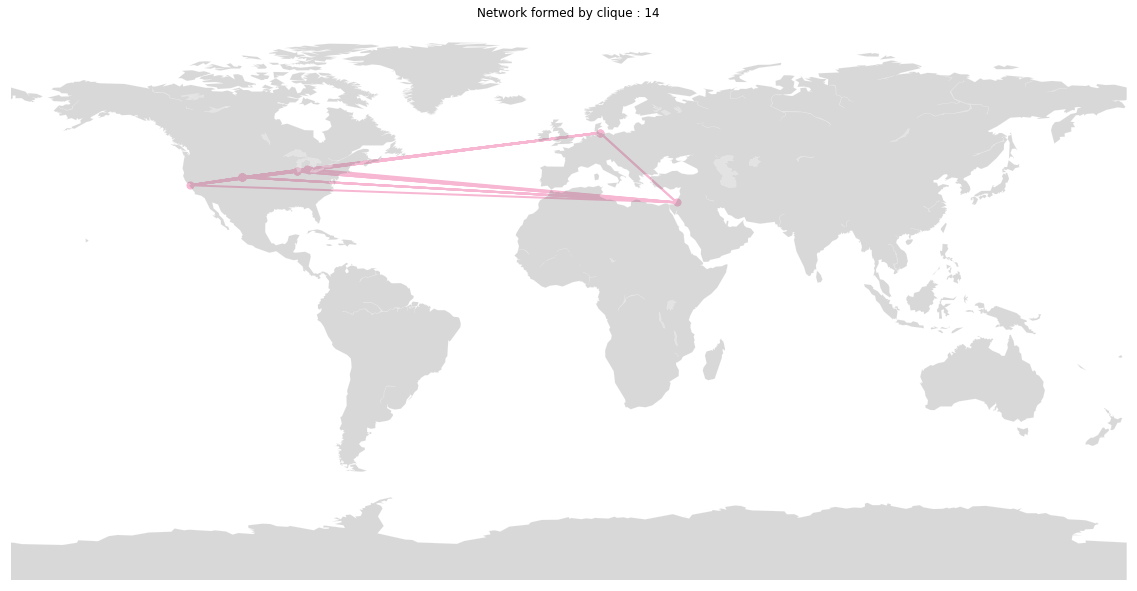

['Pellegrino, James W', 'Gane, Brian Douglas', 'Nordine, Jeffrey', 'Severance, Samuel', 'Penuel, William R.', 'Harris, Christopher J.', 'Van Horne, Katie', 'Krajcik, Joe', 'Zaidi, Sania Zahra', 'Pennock, Phyllis Haugabook', 'Briggs, Derek', 'Chattergoon, Rajendra', 'Furtak, Erin Marie', 'Neumann, Knut', 'Wingert, Kerri', 'Fortus, David']


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


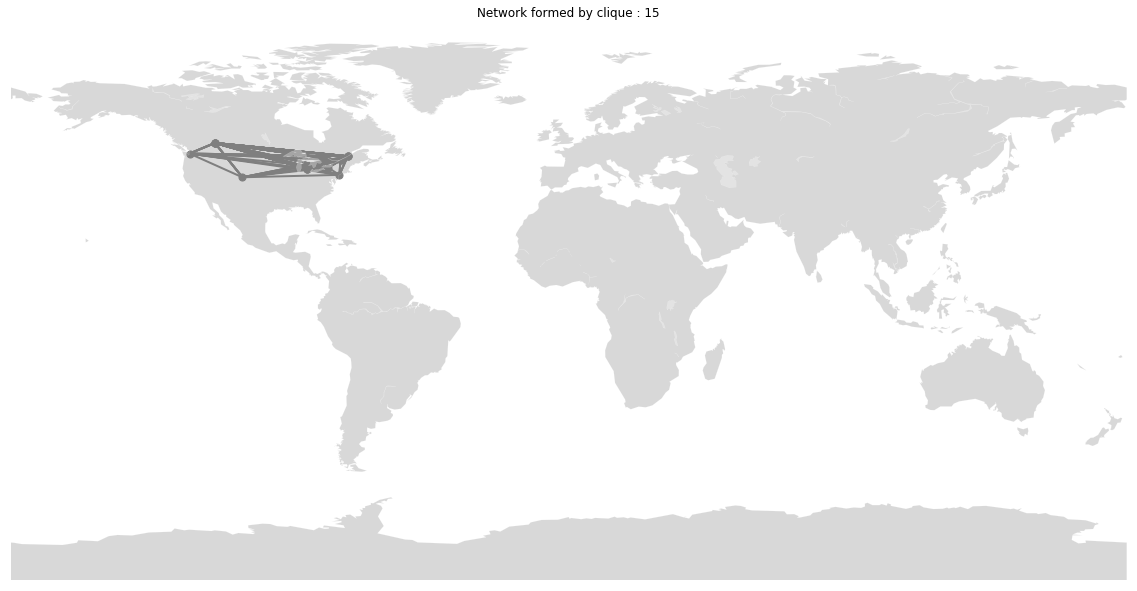

['Barton, Angela Calabrese', 'Sengupta, Pratim', 'Adams, Jennifer D', 'Barma, Sylvie', 'Vincent, Marie-Caroline', 'Voyer, Samantha', 'Rahm, Jrene', 'Touioui, Ferdous', 'Shanahan, Marie-Claire', 'Hladik, Stephanie', 'Paré, Dylan', 'Chaffee, Rachel', 'Luehmann, April', 'Greenberg, Day', 'Thompson, Jessica', 'Haganah, Sara', "O'Connor, Kevin"]


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


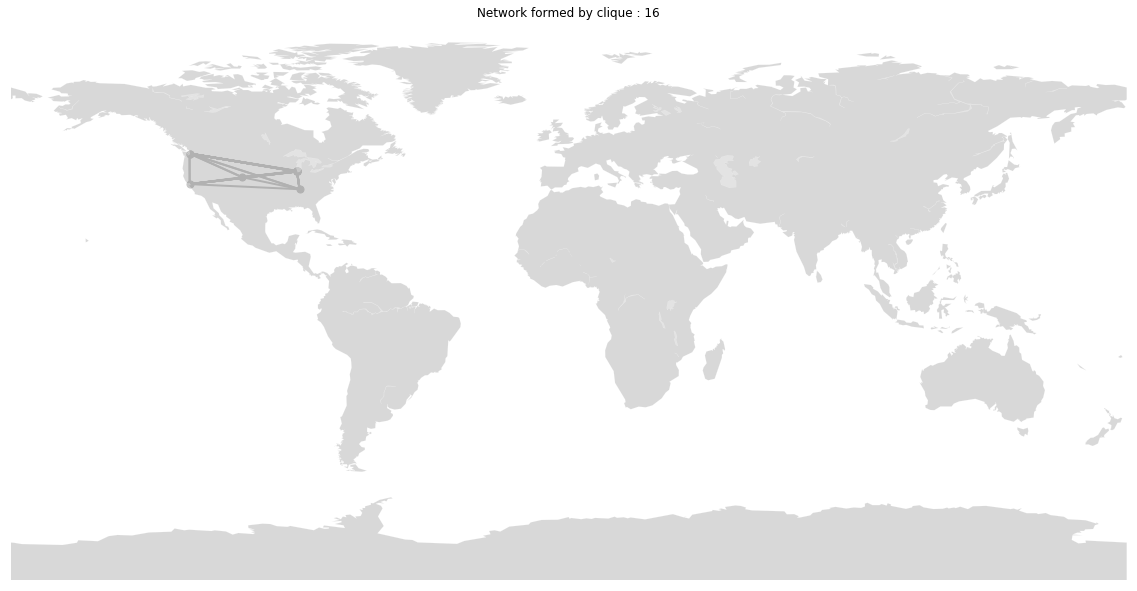

['Hall, Rogers', 'Bang, Megan', 'Radinsky, Josh', 'Jurow, A. Susan', 'Melendez, Jose W.', 'Marin, Ananda Maria', 'Nolan, Charlene Montano', 'Phillips, Nathan C', 'Lund, Virginia Killian', 'Gonzales, Wendy', 'Vossoughi, Shirin', 'Allen, Shawndra', 'Bild, David', 'Bruton, Ilana', 'Schmidt, Ani']


In [115]:

 
# prepare a color for each point depending on the continent.

 
# Add a point per position
for i, clique in enumerate(large_cliques):
    plt.figure(figsize=(20, 20))
    m=Basemap()
    m.drawmapboundary(linewidth=0)
    m.fillcontinents(color='grey', alpha=0.3)
    m.drawcoastlines(linewidth=0.1, color="white")
    data = nodes.iloc[list(clique)].copy()
    m.scatter(data['Lon'], data['Lat'], s= 50, c= palette.as_hex()[i-1], alpha=1)


    embedding = nodes.iloc[list(clique)].apply(lambda x: [x.Lon, x.Lat], axis=1)
    nx.draw_networkx_edges(main_component.subgraph(clique),  pos = embedding, 
                           edge_color=palette.as_hex()[i-1], width = 2)
    plt.title('Network formed by clique : {}'.format(i))
    plt.show()
    print(data.long_name.tolist())
    


# Using modularity to identify communities:

In [116]:
mapping = nodes.long_name.to_dict()

c = list(greedy_modularity_communities(main_component))

len(c)

We change the node size based on degree centrality, the larger the node the more collaborations the individual has:

In [117]:
member_label = matching_by_criteria(c)
nx.set_node_attributes(main_component, member_label, 'community')
node_colors = pd.Series(member_label).sort_index().tolist()
node_size = np.array(list(nx.degree_centrality(main_component).values()))

In [118]:
node_size.mean()

0.009395231853295983

In [119]:
node_size.max()

0.07572992700729926

In [120]:
np.percentile(node_size, 95)

0.02645985401459854

We label the  nodes with the largest centrality:

In [121]:
labels = nodes.iloc[list(largest_cc)]#
labels = labels.iloc[np.where(node_size >= np.percentile(node_size, 97))].long_name.to_dict()

In [122]:
labels

{37: 'Moher, Tom',
 38: 'Slotta, James',
 39: 'Acosta, Alisa',
 80: 'Bell, Philip',
 81: 'Georgen, Chris',
 93: 'Oshima, Jun',
 96: 'Zhang, Jianwei',
 97: 'Chen, Mei-Hwa',
 120: 'Danish, Joshua A.',
 131: 'Rosé, Carolyn P.',
 146: 'Kali, Yael',
 154: 'Bielaczyc, Katerine',
 170: 'Lui, Debora',
 174: 'kafai, yasmin',
 179: 'Rummel, Nikol',
 203: 'Matuk, Camillia',
 235: 'Linn, Marcia C.',
 281: 'van Aalst, Jan',
 289: 'Hakkarainen, Kai',
 322: 'Tissenbaum, Mike',
 371: 'Gerard, Libby',
 422: 'Dillenbourg, Pierre',
 466: 'Chan, Carol K. K.',
 516: 'Chen, Bodong',
 517: 'Scardamalia, Marlene',
 561: 'Hall, Rogers',
 567: 'Enyedy, Noel',
 612: 'Penuel, William R.',
 621: 'Bang, Megan',
 655: 'Humburg, Megan',
 911: 'Kidron, Adi',
 921: 'Tal, Tali',
 1030: 'Horn, Michael',
 1503: 'Kirschner, Paul A.'}

In [123]:
len(labels)

34

   1  ||  2  ||  3  ||  4  ||  5  ||  6  ||  7  ||  8  ||  9  ||  10  ||  11  ||  12  ||  13  ||  14  ||  15  ||  16  ||  17  ||  18


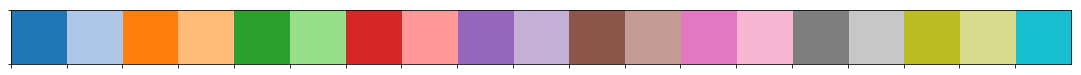

In [124]:
palette = sns.color_palette(palette='tab20', n_colors=len(c)+1)

sns.palplot(palette)
print('  ', '  ||  '.join([str(i) for i in list(range(1,len(c)+1))]))

/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


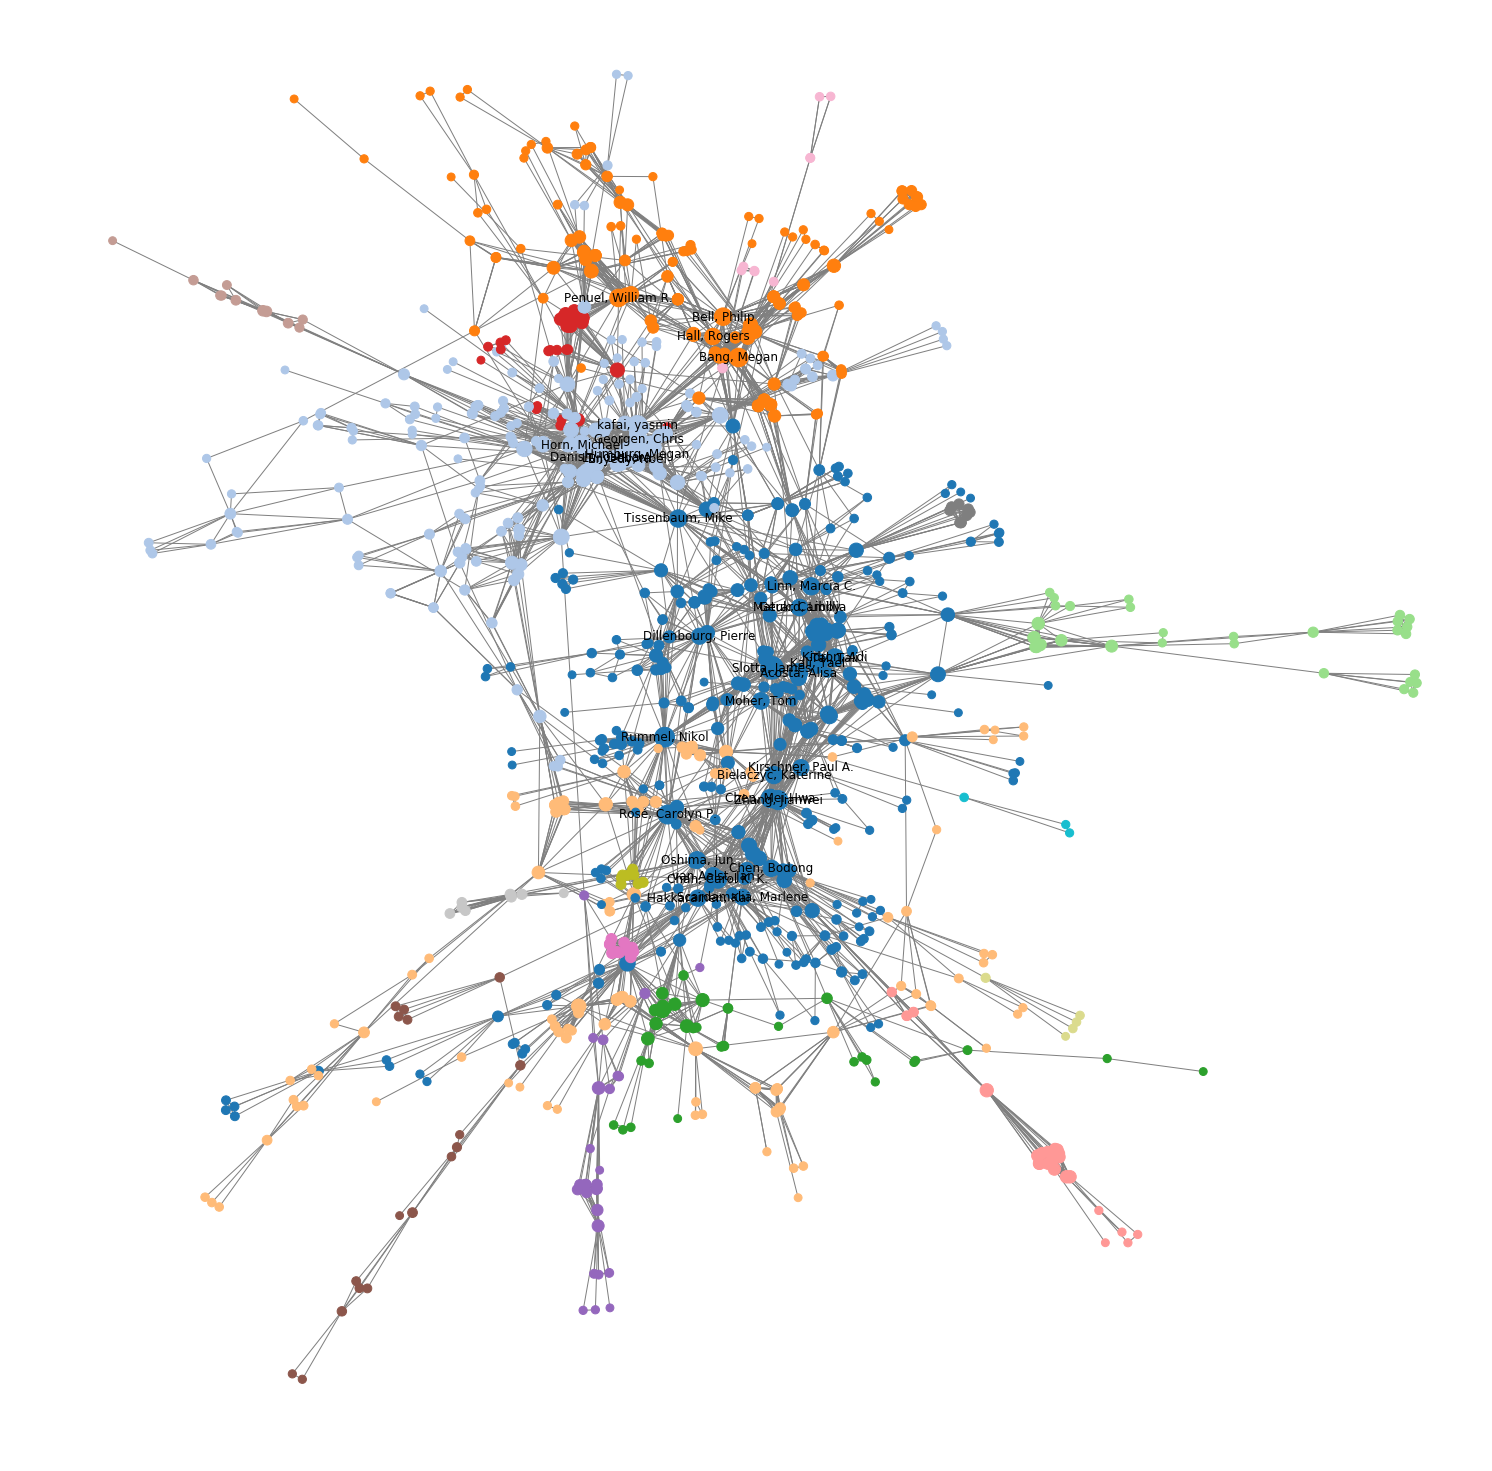

In [125]:
plt.figure(figsize=(20, 20))

nx.draw_spring(main_component, node_color=node_colors, 
                       cmap=ListedColormap(palette.as_hex()),
                       node_size=(node_size+node_size.mean())*6000,
                       labels=labels,
               edge_color='grey',
               iterations=400
              )

Here we have to code that allows to load this graph in Gephi.

In [126]:
nx.set_node_attributes(main_component, nodes.country.to_dict(), name='country')
nx.set_node_attributes(main_component, nodes.name.to_dict(), name='uni')
nx.set_node_attributes(main_component, nx.degree_centrality(graph), name='centrality')

#mapping = nodes.long_name.to_dict()
#main_component_names =nx.relabel_nodes(main_component,mapping)
#nx.write_gexf(H, 'data/main_coauthor_graph.gexf')
#nx.write_gpickle(main_component_names, 'data/coauthor_graph')

### Analyzing each subcomponent

We look at distribution of country and inst. inside these clusters (my it's associated members):

In [136]:
c = [x for x in c if len(x) > 20]

Cluster dist for cluster 1


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


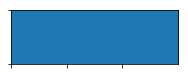

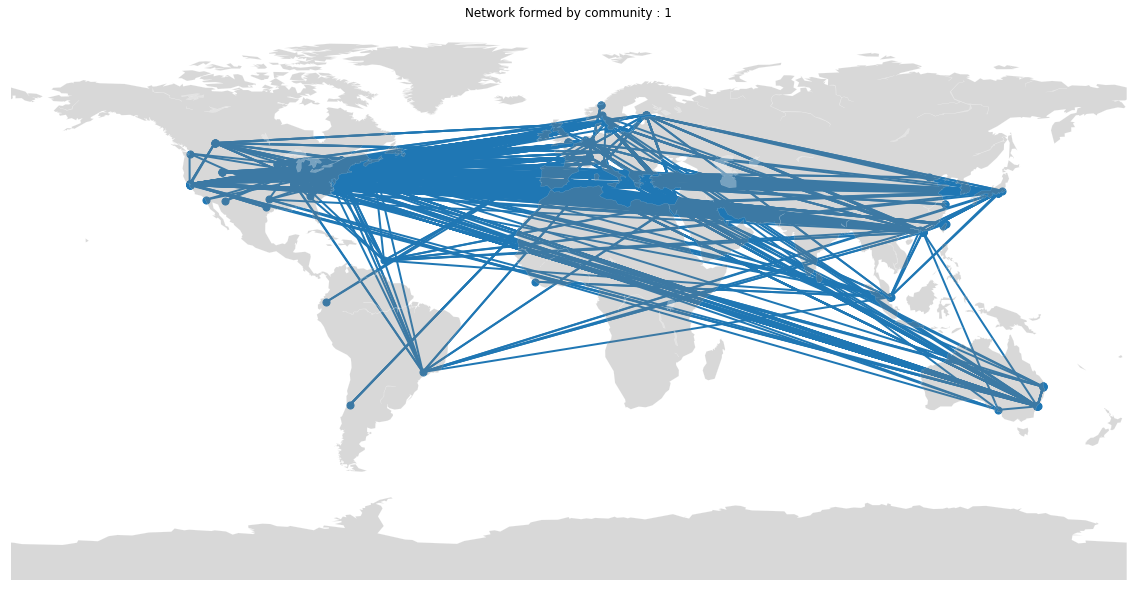

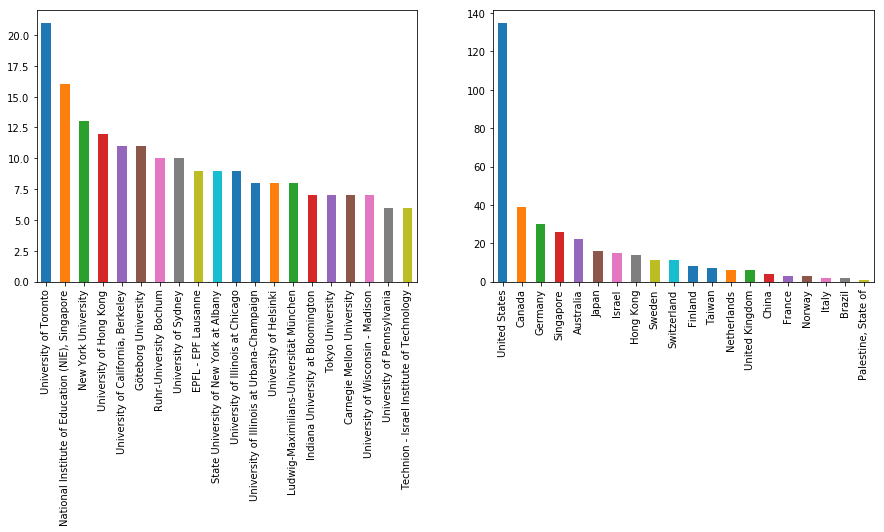

Number of countries in cluster:  25
Number of institutions in cluster:  113
Number of people in cluster:  366


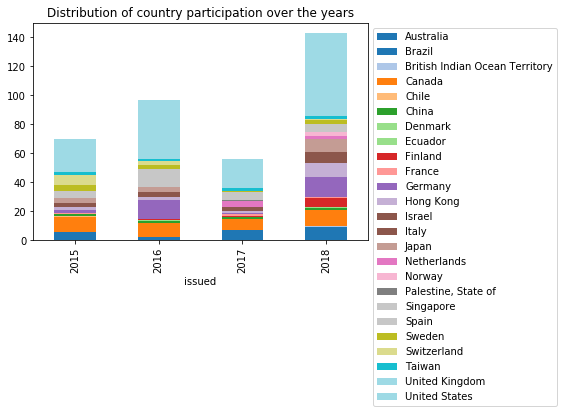

Cluster dist for cluster 2


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


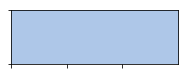

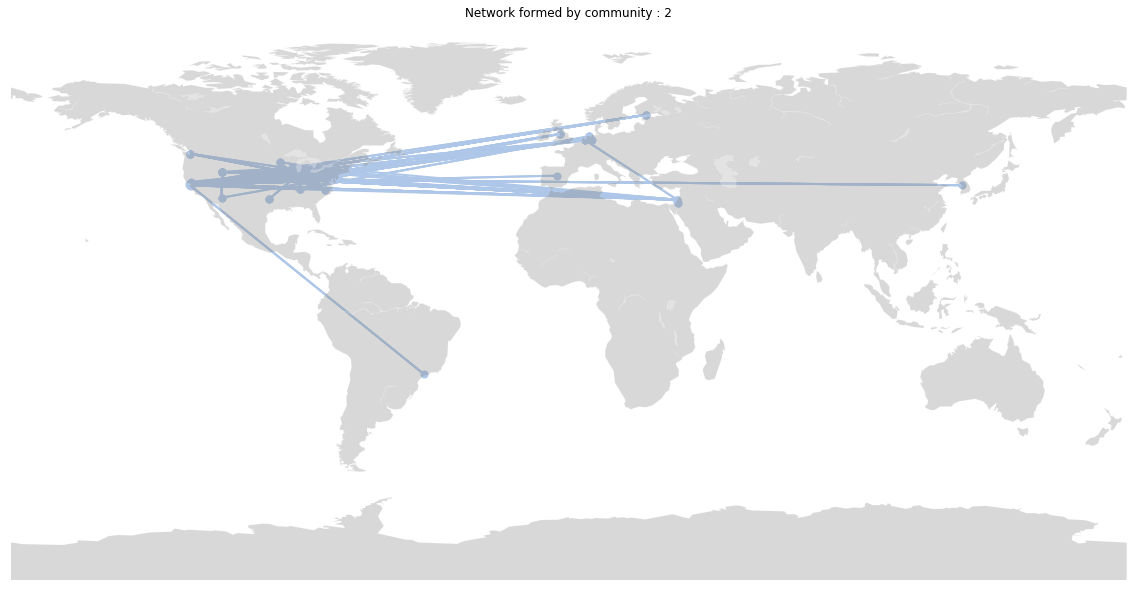

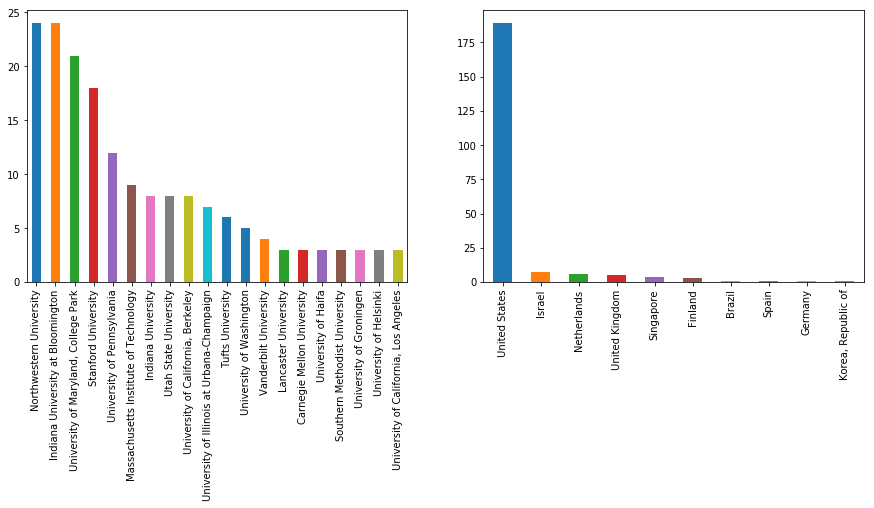

Number of countries in cluster:  10
Number of institutions in cluster:  49
Number of people in cluster:  218


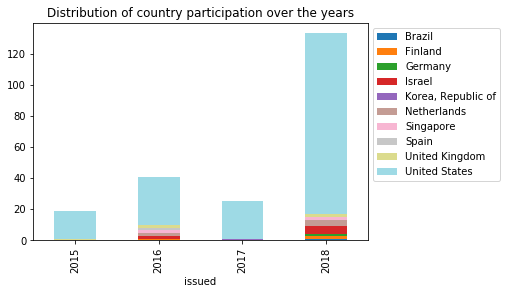

Cluster dist for cluster 3


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


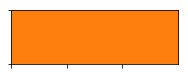

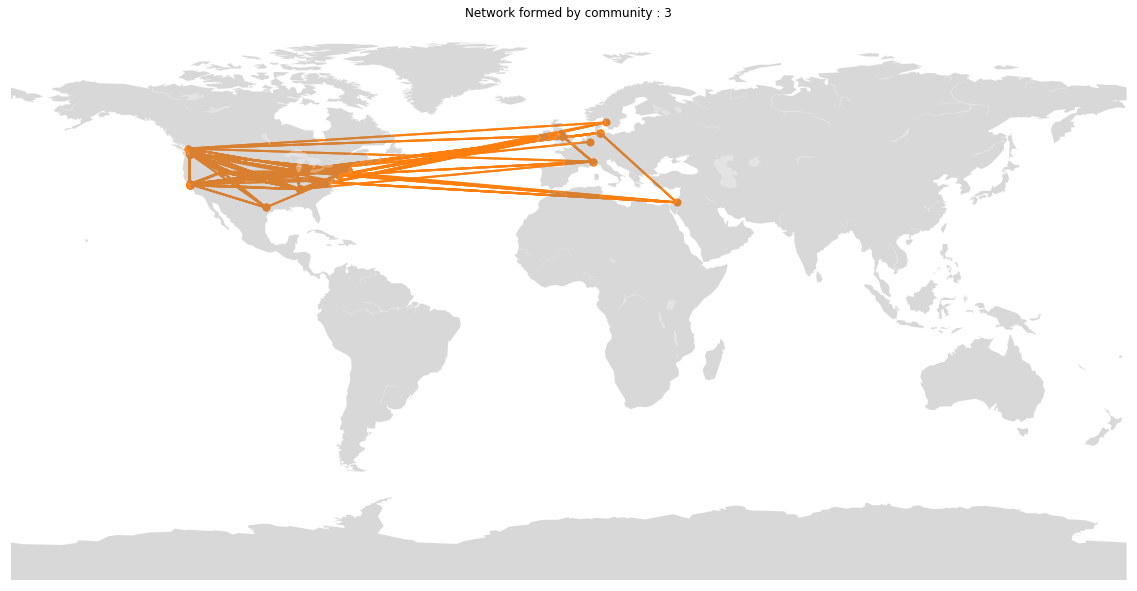

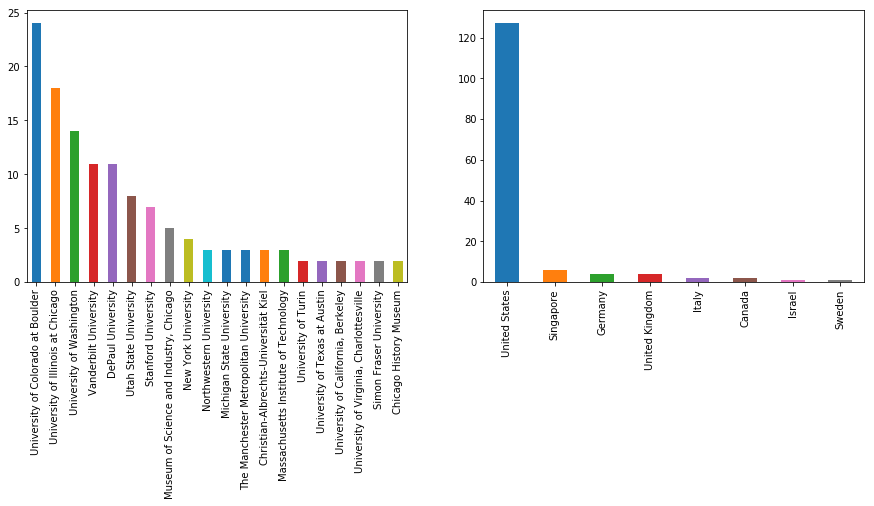

Number of countries in cluster:  8
Number of institutions in cluster:  33
Number of people in cluster:  147


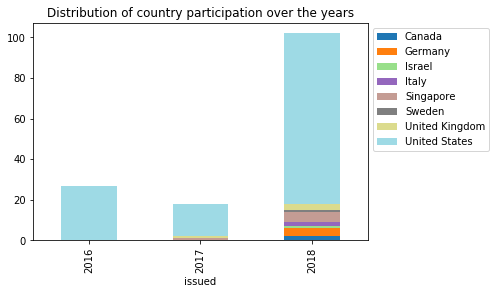

Cluster dist for cluster 4


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


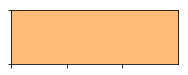

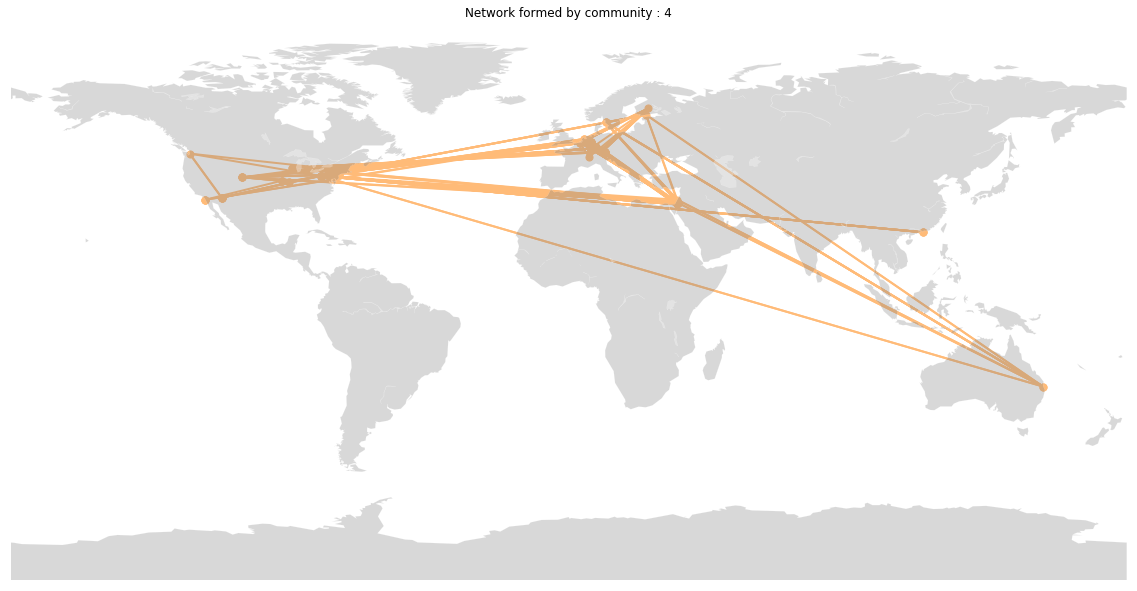

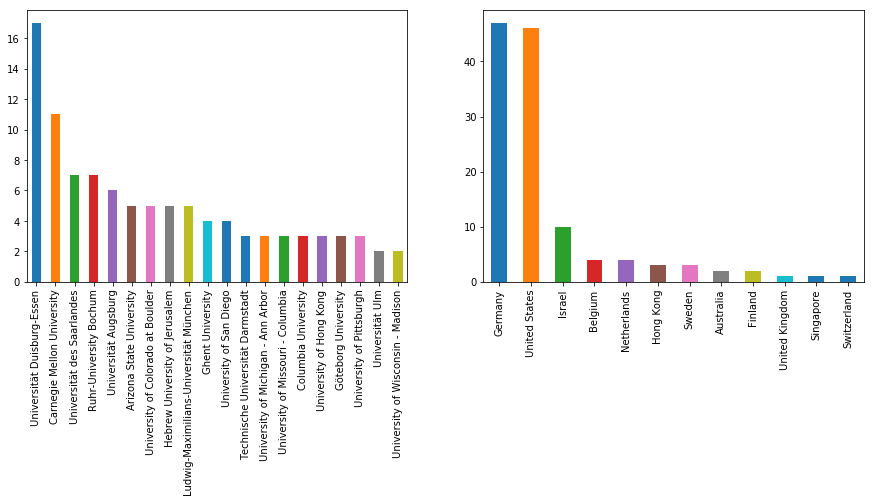

Number of countries in cluster:  12
Number of institutions in cluster:  37
Number of people in cluster:  124


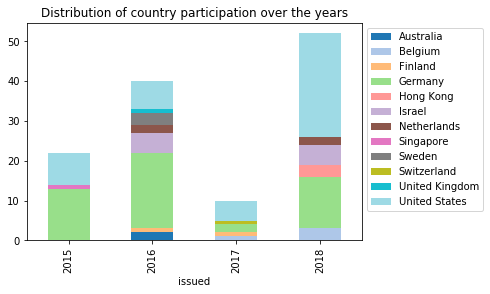

Cluster dist for cluster 5


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


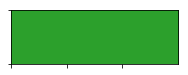

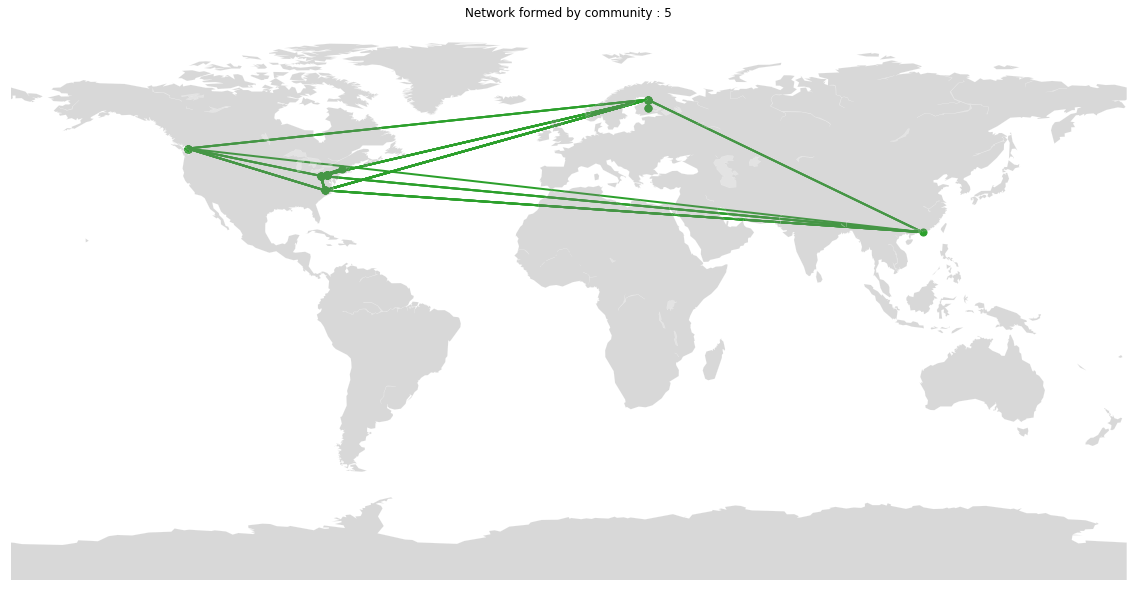

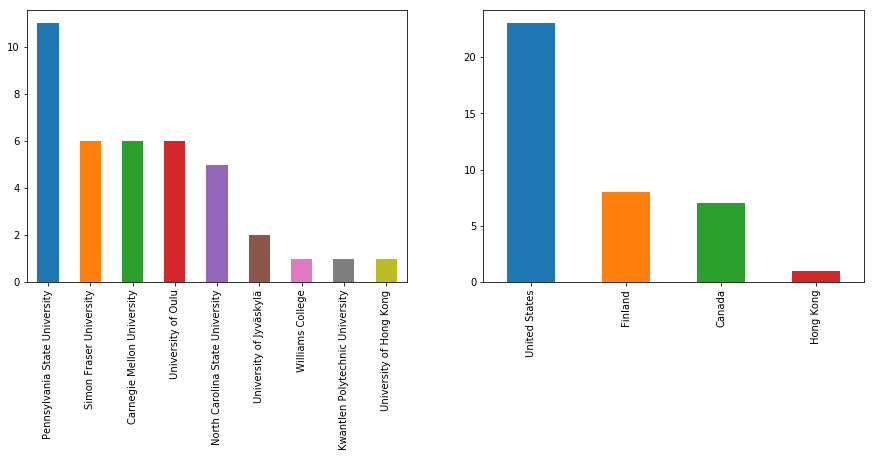

Number of countries in cluster:  4
Number of institutions in cluster:  9
Number of people in cluster:  39


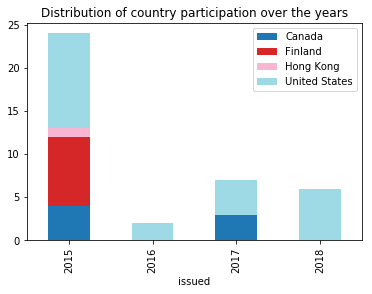

Cluster dist for cluster 6


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


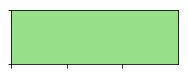

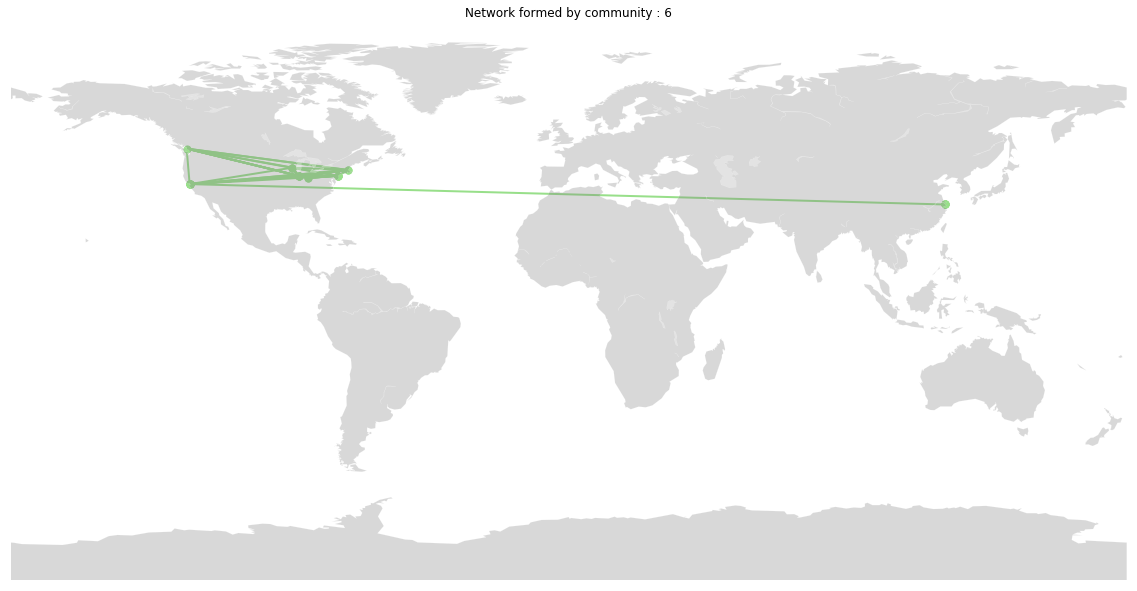

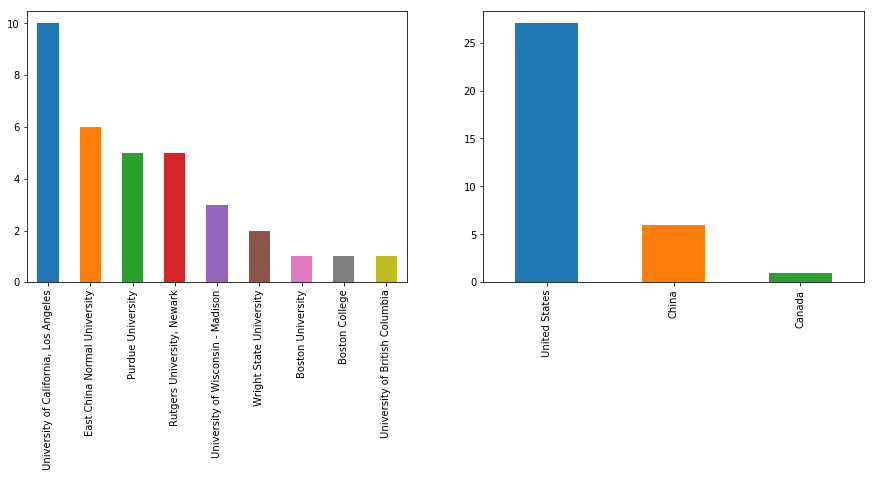

Number of countries in cluster:  3
Number of institutions in cluster:  9
Number of people in cluster:  34


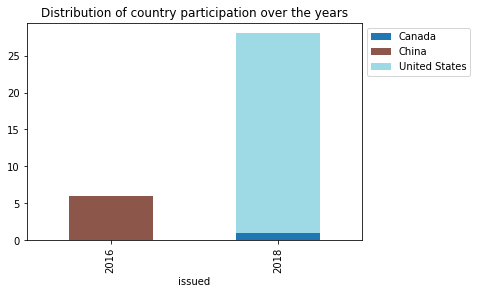

Cluster dist for cluster 7


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


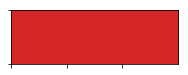

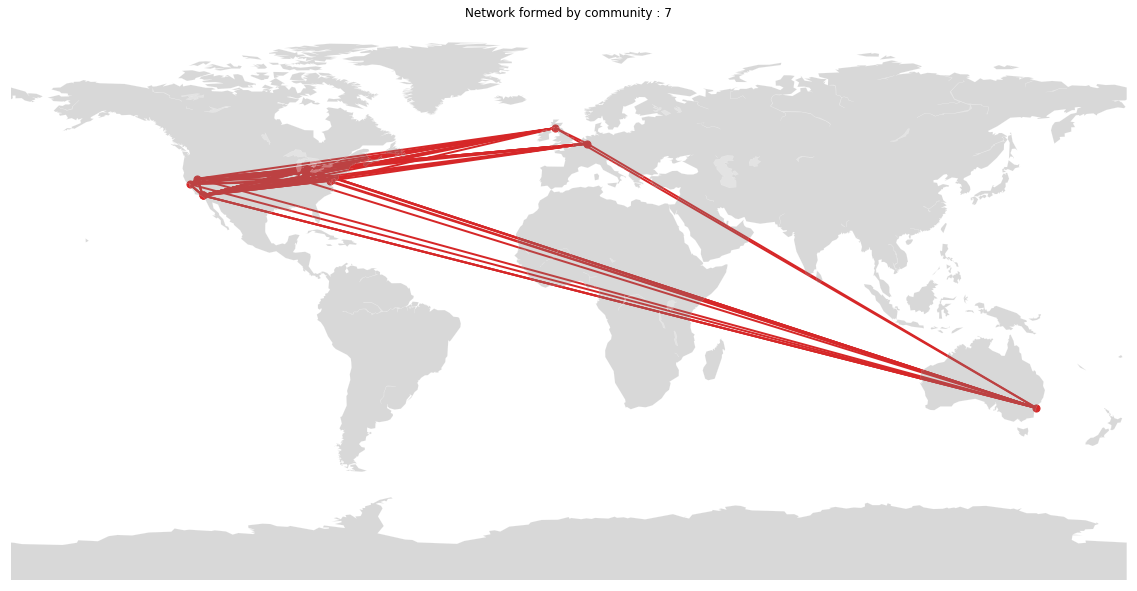

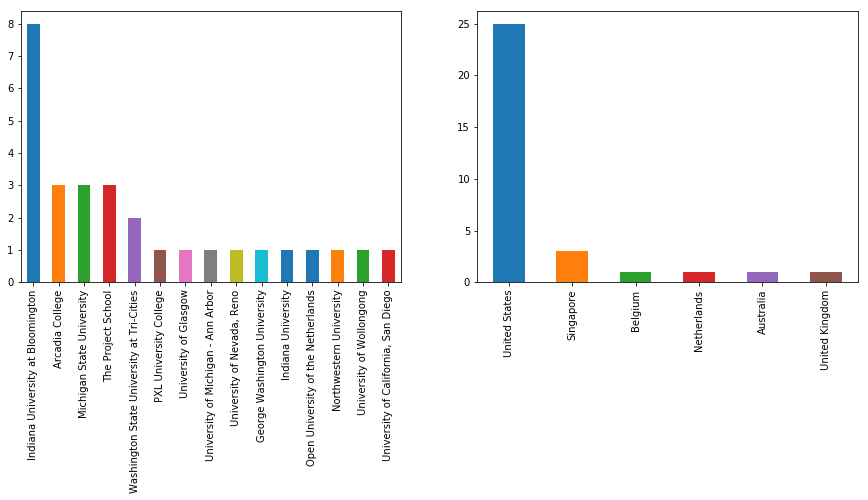

Number of countries in cluster:  6
Number of institutions in cluster:  16
Number of people in cluster:  32


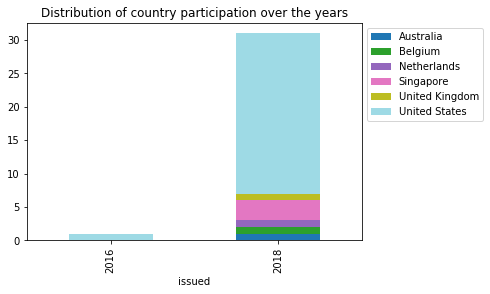

Cluster dist for cluster 8


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


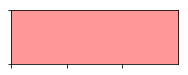

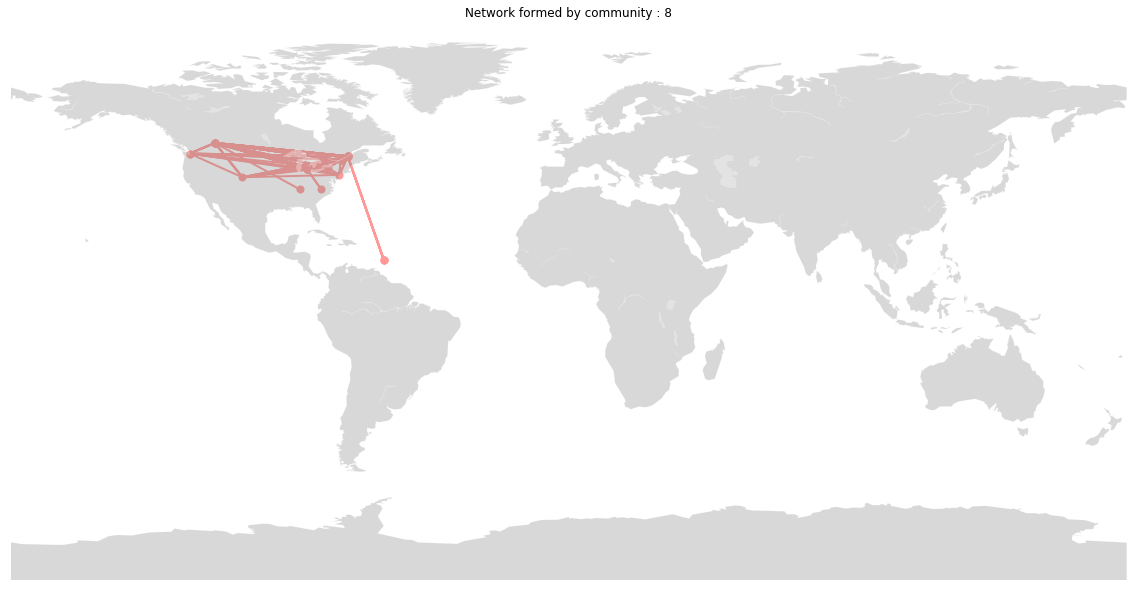

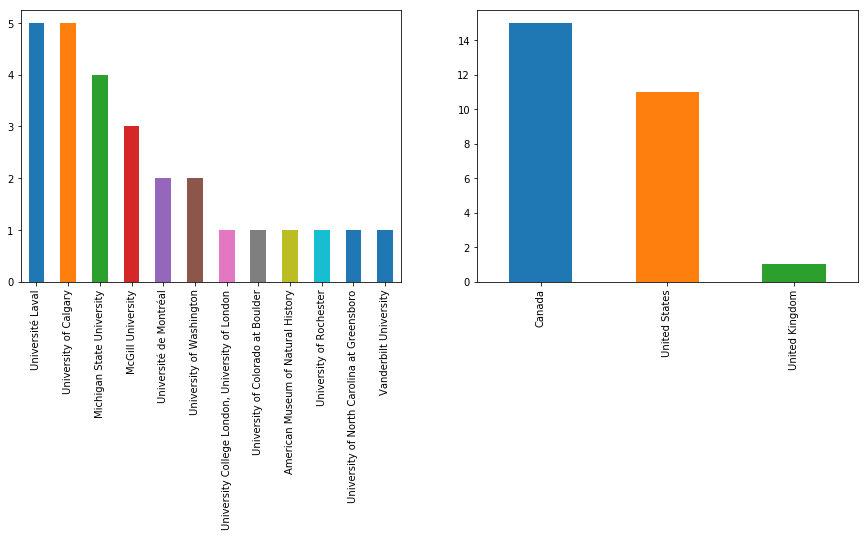

Number of countries in cluster:  3
Number of institutions in cluster:  12
Number of people in cluster:  27


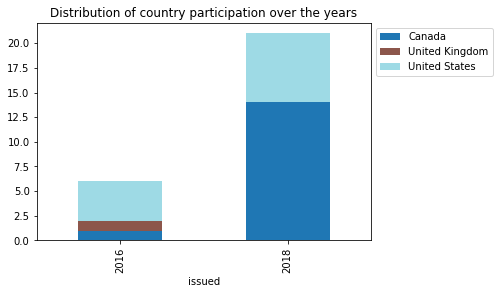

Cluster dist for cluster 9


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


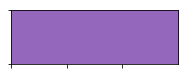

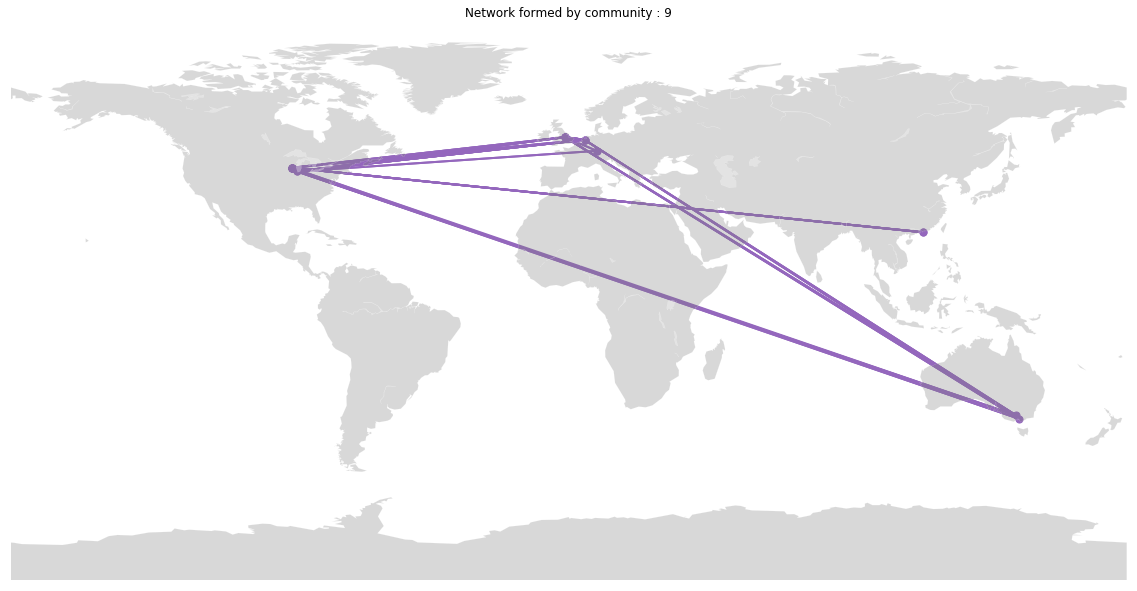

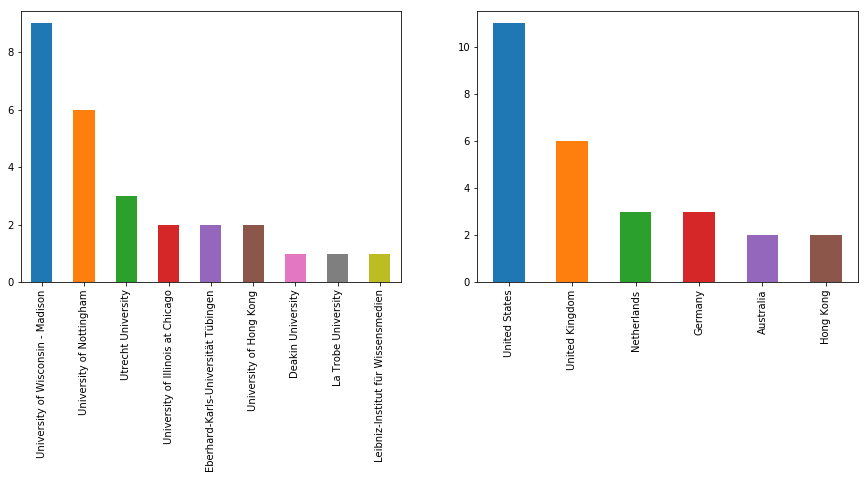

Number of countries in cluster:  6
Number of institutions in cluster:  9
Number of people in cluster:  27


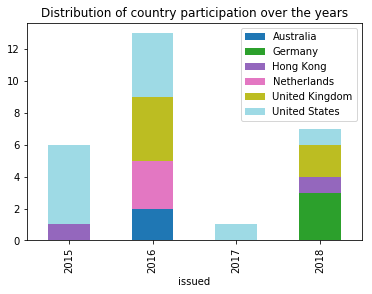

In [137]:
for i,cluster in enumerate(c):
    print(f'Cluster dist for cluster {i+1}')
    sns.palplot(palette[i])
    
    plt.figure(figsize=(20, 20))
    m=Basemap()
    m.drawmapboundary(linewidth=0)
    m.fillcontinents(color='grey', alpha=0.3)
    m.drawcoastlines(linewidth=0.1, color="white")
    data = nodes.iloc[list(cluster)].copy()
    m.scatter(data['Lon'], data['Lat'], s= 50, c= palette.as_hex()[i], alpha=1)


    embedding = nodes.iloc[list(cluster)].apply(lambda x: [x.Lon, x.Lat], axis=1)
    nx.draw_networkx_edges(main_component.subgraph(cluster),  pos = embedding, 
                           edge_color=palette.as_hex()[i], width = 2)
    plt.title('Network formed by community : {}'.format(i+1))
    plt.show()
    
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    nodes.iloc[list(cluster)].name.value_counts().head(20).plot('bar')
    plt.subplot(122)
    nodes.iloc[list(cluster)].country.value_counts().head(20).plot('bar')
    plt.show()
    print('Number of countries in cluster: ', len(nodes.iloc[list(cluster)].country.unique()))
    print('Number of institutions in cluster: ', len(nodes.iloc[list(cluster)].name.unique()))
    print('Number of people in cluster: ', len(nodes.iloc[list(cluster)].long_name.unique()))
    
    #plt.title('Number of people submitting over the years over the years')
    
   
    plot_df = pd.DataFrame(nodes.iloc[list(cluster)].groupby(['issued'])\
                           .country.value_counts()).rename(columns={'country':'count'}).reset_index()
    plot_df.pivot(index='issued', columns='country', values='count').plot(kind='bar', stacked=True, colormap=plt.cm.tab20)
    plt.title('Distribution of country participation over the years')
    plt.legend(bbox_to_anchor=(1, 1))
    
    plt.show()    
    


## An other way to partition the graph: Hierarchical clustering

## Looking at people moving around

We now look at people who moved from one country to an other within the period of the papers in the parsed papers:

We have to look at years as well to avoid duplicates, however, this could be due to people being associated to multiple institutions at once.

In [128]:
name_country = associations[['name', 'mail', 'country', 'long_name', 'shortend_names','issued']]

In [129]:
#Add year to see
df = pd.merge(name_country, name_country, on='long_name').dropna()
df = df[df.country_x != df.country_y]
df['set_countries'] = df.apply(lambda x: ''.join(sorted([x.country_x, x.country_y, str(x.issued_x), str(x.issued_y)])), axis=1)
df[~df[['long_name', 'set_countries']].duplicated()].head()

name_x                    mail_x country_x  \
468  University of Toronto    jim.slotta@utoronto.ca    Canada   
477  University of Toronto    jim.slotta@utoronto.ca    Canada   
544  University of Toronto  alisa.acosta@utoronto.ca    Canada   
550  University of Toronto  alisa.acosta@utoronto.ca    Canada   
556  University of Toronto  alisa.acosta@utoronto.ca    Canada   

            long_name shortend_names_x  issued_x               name_y  \
468  Slotta, James D.     Slotta J. D.      2015       Boston College   
477  Slotta, James D.          Kali Y.      2016       Boston College   
544     Acosta, Alisa     Slotta J. D.      2015  New York University   
550     Acosta, Alisa    Charles E. S.      2016  New York University   
556     Acosta, Alisa        Acosta A.      2018  New York University   

             mail_y      country_y shortend_names_y  issued_y  \
468   slotta@bc.edu  United States     Slotta J. D.      2017   
477   slotta@bc.edu  United States     Slotta J. D.      2017   
544  th1425@nyu.edu  United States            Clark      2018   
550  th1425@nyu.edu  United States            Clark      2018   
556  th1425@nyu.edu  United States            Clark      2018   

                   set_countries  
468  20152017CanadaUnited States  
477  20162017CanadaUnited States  
544  20152018CanadaUnited States  
550  20162018CanadaUnited States  
556  20182018CanadaUnited States

In [130]:
df = pd.merge(name_country, name_country, on='long_name').dropna()
df['set_countries'] = df.apply(lambda x: ''.join(sorted([x.name_x, x.name_y, str(x.issued_x), str(x.issued_y)])), axis=1)
df = df[~df[['long_name', 'set_countries']].duplicated()]
df[(df.name_x != df.name_y) & (df.country_x != df.country_y)][['long_name','shortend_names_y', 'name_x', 'name_y', 'issued_x', 'issued_y']].head()

long_name shortend_names_y  \
468  Slotta, James D.     Slotta J. D.   
477  Slotta, James D.     Slotta J. D.   
495  Slotta, James D.     Slotta J. D.   
544     Acosta, Alisa            Clark   
550     Acosta, Alisa            Clark   

                                                name_x               name_y  \
468                              University of Toronto       Boston College   
477                              University of Toronto       Boston College   
495  Ontario Institute for Studies in Education, Un...       Boston College   
544                              University of Toronto  New York University   
550                              University of Toronto  New York University   

     issued_x  issued_y  
468      2015      2017  
477      2016      2017  
495      2016      2017  
544      2015      2018  
550      2016      2018

Number of people that changed organisation:

#TODO fix years

In [131]:
df[(df.name_x != df.name_y) & (df.country_x == df.country_y)].drop_duplicates().head()

name_x                            mail_x  \
60   Indiana University at Bloomington               agomoll90@gmail.com   
149               Universität Augsburg  ingo.kollar@phil.uni-augsburg.de   
150               Universität Augsburg  ingo.kollar@phil.uni-augsburg.de   
159               Universität Augsburg  ingo.kollar@phil.uni-augsburg.de   
160               Universität Augsburg  ingo.kollar@phil.uni-augsburg.de   

         country_x             long_name shortend_names_x  issued_x  \
60   United States  Gomoll, Andrea Sarah     Gomoll A. S.      2018   
149        Germany          Kollar, Ingo        Kollar I.      2016   
150        Germany          Kollar, Ingo        Kollar I.      2016   
159        Germany          Kollar, Ingo        Kollar I.      2018   
160        Germany          Kollar, Ingo        Kollar I.      2018   

                                     name_y                       mail_y  \
60                       Indiana University               agomoll@iu.edu   
149  Ludwig-Maximilians-Universität München       ingo.kollar@psy.lmu.de   
150  Ludwig-Maximilians-Universität München  christian.ghanem@psy.lmu.de   
159  Ludwig-Maximilians-Universität München       ingo.kollar@psy.lmu.de   
160  Ludwig-Maximilians-Universität München  christian.ghanem@psy.lmu.de   

         country_y shortend_names_y  issued_y  \
60   United States     Gomoll A. S.      2018   
149        Germany        Kollar I.      2015   
150        Germany       Flekova L.      2016   
159        Germany        Kollar I.      2015   
160        Germany       Flekova L.      2016   

                                         set_countries  
60   20182018Indiana UniversityIndiana University a...  
149  20152016Ludwig-Maximilians-Universität München...  
150  20162016Ludwig-Maximilians-Universität München...  
159  20152018Ludwig-Maximilians-Universität München...  
160  20162018Ludwig-Maximilians-Universität München...

## Plotting edges by year: